In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import joblib

from matplotlib import rc
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders import HashingEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
rc('font', family='AppleGothic')

In [3]:
file_path = "/Users/idoyeong/계명대학교/sas공모전/DATA/TRAIN_DATA.csv"

In [4]:
df = pd.read_csv(file_path, encoding='cp949')

In [5]:
df.head()

,DATA_YM,AREA_ID,AREA_NM,DIST_CD,DIST_NM,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,FAC_RETAIL,FAC_MEDI,FAC_YOSE,FAC_TRAIN,FAC_SPORT,FAC_STAY,FAC_LEISURE,TOTAL_GAS,CMRC_GAS,TOTAL_ELEC
0,202303,9626,중앙로역_4,27110,중구,538.0,266.0,88.0,6.0,3.0,2.0,3.0,0.0,0.0,0.0,16.0,3.0,517520,466070,1174.570
1,202303,10350,황리단길,47130,경주시,765.0,72.0,174.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,322681,318143,571.137
2,202212,9547,농소1동,31200,북구,343.0,74.0,161.0,1.0,3.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,921843,726861,1094.982
3,202312,9995,심석고등학교,41360,남양주시,129.0,4.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226095,223952,594.064
4,202301,9248,고덕역,11740,강동구,34.0,2.0,14.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1884854,886279,2708.273


In [6]:
# 1. 영어 컬럼명 -> 한글 컬럼명 매핑 딕셔너리 정의
column_rename_dict = {
    'DATA_YM': '데이터_작성월',
    'AREA_ID': '상권_코드',
    'AREA_NM': '상권_명칭',
    'DIST_CD': '지역_코드',
    'DIST_NM': '지역_명칭',
    'TOTAL_BIDG': '총_건물수',
    'FAC_NEIGH_1': '편의시설_1종',
    'FAC_NEIGH_2': '편의시설_2종',
    'FAC_CULT_MTG': '문화집회시설',
    'FAC_RELG': '종교시설',
    'FAC_RETAIL': '판매시설',
    'FAC_MEDI': '의료시설',
    'FAC_YOSE': '아동노인복지',
    'FAC_TRAIN': '수련원',
    'FAC_SPORT': '운동시설',
    'FAC_STAY': '숙박시설',
    'FAC_LEISURE': '여가휴식시설',
    'TOTAL_GAS': '총_가스사용량',
    'CMRC_GAS': '상업용_가스사용량',
    'TOTAL_ELEC': '종속변수' 
}

# 2. DataFrame 컬럼명 변경 적용
df.rename(columns=column_rename_dict, inplace=True)

print("변경된 컬럼 목록:")
print(df.columns)

변경된 컬럼 목록:
Index(['데이터_작성월', '상권_코드', '상권_명칭', '지역_코드', '지역_명칭', '총_건물수', '편의시설_1종',
       '편의시설_2종', '문화집회시설', '종교시설', '판매시설', '의료시설', '아동노인복지', '수련원', '운동시설',
       '숙박시설', '여가휴식시설', '총_가스사용량', '상업용_가스사용량', '종속변수'],
      dtype='object')


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26099 entries, 0 to 26098
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   데이터_작성월    26099 non-null  int64  
 1   상권_코드      26099 non-null  int64  
 2   상권_명칭      26099 non-null  object 
 3   지역_코드      26099 non-null  int64  
 4   지역_명칭      26099 non-null  object 
 5   총_건물수      26096 non-null  float64
 6   편의시설_1종    26096 non-null  float64
 7   편의시설_2종    26096 non-null  float64
 8   문화집회시설     26096 non-null  float64
 9   종교시설       26096 non-null  float64
 10  판매시설       26096 non-null  float64
 11  의료시설       26096 non-null  float64
 12  아동노인복지     26096 non-null  float64
 13  수련원        26096 non-null  float64
 14  운동시설       26096 non-null  float64
 15  숙박시설       26096 non-null  float64
 16  여가휴식시설     26096 non-null  float64
 17  총_가스사용량    26099 non-null  int64  
 18  상업용_가스사용량  26099 non-null  int64  
 19  종속변수       26099 non-null  float64
dtypes: flo

In [8]:
df.describe()

,데이터_작성월,상권_코드,지역_코드,총_건물수,편의시설_1종,편의시설_2종,문화집회시설,종교시설,판매시설,의료시설,아동노인복지,수련원,운동시설,숙박시설,여가휴식시설,총_가스사용량,상업용_가스사용량,종속변수
count,26099.000000,26099.000000,26099.000000,26096.000000,26096.000000,26096.000000,26096.000000,26096.000000,26096.000000,26096.000000,26096.000000,26096.000000,26096.000000,26096.000000,26096.000000,2.609900e+04,2.609900e+04,26099.000000
mean,202320.975363,9740.424959,33096.153148,178.954476,44.329591,42.732948,0.290696,0.495172,1.086987,0.575069,0.581085,0.014830,0.114960,5.951219,1.583423,5.767216e+05,3.516152e+05,1460.103342
std,72.900406,352.368651,13612.419013,188.847242,66.857206,51.148331,0.854388,0.944714,2.456789,1.048232,1.079454,0.120874,0.365452,11.767048,4.142390,1.012306e+06,6.550921e+05,2053.871482
min,202207.000000,9138.000000,11110.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,202301.000000,9437.000000,26290.000000,51.000000,7.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.036100e+04,4.101200e+04,368.864500
50%,202308.000000,9734.000000,41117.000000,117.000000,20.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.512790e+05,1.639980e+05,822.388000
75%,202404.000000,10040.000000,44230.000000,246.000000,51.000000,59.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,6.000000,1.000000,6.531905e+05,4.087160e+05,1773.142500
max,202410.000000,10376.000000,52800.000000,1530.000000,553.000000,872.000000,18.000000,15.000000,67.000000,7.000000,9.000000,1.000000,3.000000,130.000000,70.000000,2.125008e+07,1.953260e+07,27171.719000


In [9]:
df.isnull().sum()

데이터_작성월      0
상권_코드        0
상권_명칭        0
지역_코드        0
지역_명칭        0
총_건물수        3
편의시설_1종      3
편의시설_2종      3
문화집회시설       3
종교시설         3
판매시설         3
의료시설         3
아동노인복지       3
수련원          3
운동시설         3
숙박시설         3
여가휴식시설       3
총_가스사용량      0
상업용_가스사용량    0
종속변수         0
dtype: int64

In [10]:
# 행별로 Null 확인
null_row = df.isnull().any(axis=1)
rows_with_nulls = df[null_row]
print(rows_with_nulls)

       데이터_작성월  상권_코드  상권_명칭  지역_코드 지역_명칭  총_건물수  편의시설_1종  편의시설_2종  문화집회시설  \
14565   202307   9185  종묘앞_1  11110   종로구    NaN      NaN      NaN     NaN   
15812   202306   9185  종묘앞_1  11110   종로구    NaN      NaN      NaN     NaN   
16069   202303   9185  종묘앞_1  11110   종로구    NaN      NaN      NaN     NaN   

       종교시설  판매시설  의료시설  아동노인복지  수련원  운동시설  숙박시설  여가휴식시설  총_가스사용량  상업용_가스사용량  \
14565   NaN   NaN   NaN     NaN  NaN   NaN   NaN     NaN        0          0   
15812   NaN   NaN   NaN     NaN  NaN   NaN   NaN     NaN        0          0   
16069   NaN   NaN   NaN     NaN  NaN   NaN   NaN     NaN        0          0   

        종속변수  
14565  1.008  
15812  1.343  
16069  1.319  


In [11]:
target_value = '종묘앞_1'
target_column = '상권_명칭'

condition = (df[target_column] == target_value)

# 조건을 만족하는 행들만 필터링
filtered_df = df[condition]

print(filtered_df)


       데이터_작성월  상권_코드  상권_명칭  지역_코드 지역_명칭  총_건물수  편의시설_1종  편의시설_2종  문화집회시설  \
79      202408   9185  종묘앞_1  11110   종로구    0.0      0.0      0.0     0.0   
1370    202410   9185  종묘앞_1  11110   종로구  114.0     52.0     21.0     0.0   
1466    202405   9185  종묘앞_1  11110   종로구    0.0      0.0      0.0     0.0   
3751    202406   9185  종묘앞_1  11110   종로구    0.0      0.0      0.0     0.0   
4677    202301   9185  종묘앞_1  11110   종로구   52.0     37.0      8.0     0.0   
5571    202311   9185  종묘앞_1  11110   종로구    0.0      0.0      0.0     0.0   
10493   202212   9185  종묘앞_1  11110   종로구   52.0     37.0      8.0     0.0   
11035   202210   9185  종묘앞_1  11110   종로구   58.0     40.0     11.0     0.0   
12517   202303   9185  종묘앞_1  11110   종로구    1.0      1.0      0.0     0.0   
14565   202307   9185  종묘앞_1  11110   종로구    NaN      NaN      NaN     NaN   
15812   202306   9185  종묘앞_1  11110   종로구    NaN      NaN      NaN     NaN   
16069   202303   9185  종묘앞_1  11110   종로구    NaN      NaN      N

In [12]:
# [시설 개수 관련 컬럼들의 결측치(NaN)를 0으로 대체함]
# 이유: 해당 컬럼들은 시설물의 개수를 나타내며, 데이터 확인 결과 실제 값이 0인 경우가 빈번하게 관찰됨.
# 따라서 정보가 누락된 경우(NaN)도 실제 시설 개수가 0일 가능성이 높다고 판단하여 0으로 대체함.
df = df.fillna(0)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26099 entries, 0 to 26098
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   데이터_작성월    26099 non-null  int64  
 1   상권_코드      26099 non-null  int64  
 2   상권_명칭      26099 non-null  object 
 3   지역_코드      26099 non-null  int64  
 4   지역_명칭      26099 non-null  object 
 5   총_건물수      26099 non-null  float64
 6   편의시설_1종    26099 non-null  float64
 7   편의시설_2종    26099 non-null  float64
 8   문화집회시설     26099 non-null  float64
 9   종교시설       26099 non-null  float64
 10  판매시설       26099 non-null  float64
 11  의료시설       26099 non-null  float64
 12  아동노인복지     26099 non-null  float64
 13  수련원        26099 non-null  float64
 14  운동시설       26099 non-null  float64
 15  숙박시설       26099 non-null  float64
 16  여가휴식시설     26099 non-null  float64
 17  총_가스사용량    26099 non-null  int64  
 18  상업용_가스사용량  26099 non-null  int64  
 19  종속변수       26099 non-null  float64
dtypes: flo

In [14]:
df['지역_코드'].nunique()

271

In [15]:
df['상권_코드'].nunique()

1166

In [16]:
df.corr(numeric_only=True)

,데이터_작성월,상권_코드,지역_코드,총_건물수,편의시설_1종,편의시설_2종,문화집회시설,종교시설,판매시설,의료시설,아동노인복지,수련원,운동시설,숙박시설,여가휴식시설,총_가스사용량,상업용_가스사용량,종속변수
데이터_작성월,1.000000,-0.001737,0.019549,-0.034770,-0.035955,-0.039541,-0.014678,-0.012418,-0.018592,-0.027244,-0.006213,0.000107,-0.004309,-0.033617,-0.021089,0.005850,-0.000065,-0.024666
상권_코드,-0.001737,1.000000,0.600765,-0.040460,-0.023687,-0.136832,-0.054541,0.000235,-0.036873,0.017776,0.075214,0.005578,0.019893,-0.006332,-0.050856,-0.230883,-0.180696,-0.176933
지역_코드,0.019549,0.600765,1.000000,0.174362,0.155380,0.002459,0.024588,0.107904,0.037226,0.085178,0.199178,-0.001829,0.081060,0.122937,0.187557,-0.306449,-0.242376,-0.225352
총_건물수,-0.034770,-0.040460,0.174362,1.000000,0.839409,0.792130,0.353344,0.469043,0.329635,0.371600,0.464994,0.050064,0.152050,0.536524,0.512886,0.121966,0.159422,0.151882
편의시설_1종,-0.035955,-0.023687,0.155380,0.839409,1.000000,0.651607,0.366764,0.369938,0.395748,0.388863,0.324281,0.085252,0.119226,0.482234,0.503168,0.065137,0.115033,0.115979
편의시설_2종,-0.039541,-0.136832,0.002459,0.792130,0.651607,1.000000,0.352146,0.399590,0.303856,0.311754,0.348931,0.036887,0.180493,0.462884,0.407272,0.268166,0.315327,0.282686
문화집회시설,-0.014678,-0.054541,0.024588,0.353344,0.366764,0.352146,1.000000,0.274464,0.163377,0.222241,0.180054,0.028021,0.087631,0.212842,0.223551,0.181730,0.170908,0.166303
종교시설,-0.012418,0.000235,0.107904,0.469043,0.369938,0.399590,0.274464,1.000000,0.096596,0.193049,0.384117,0.025971,0.132046,0.204993,0.177243,0.109743,0.081740,0.090325
판매시설,-0.018592,-0.036873,0.037226,0.329635,0.395748,0.303856,0.163377,0.096596,1.000000,0.193418,0.087158,0.024439,0.071381,0.297960,0.239959,0.150634,0.199597,0.206843
의료시설,-0.027244,0.017776,0.085178,0.371600,0.388863,0.311754,0.222241,0.193049,0.193418,1.000000,0.184356,-0.000159,0.075224,0.381020,0.360017,0.107632,0.126172,0.154966


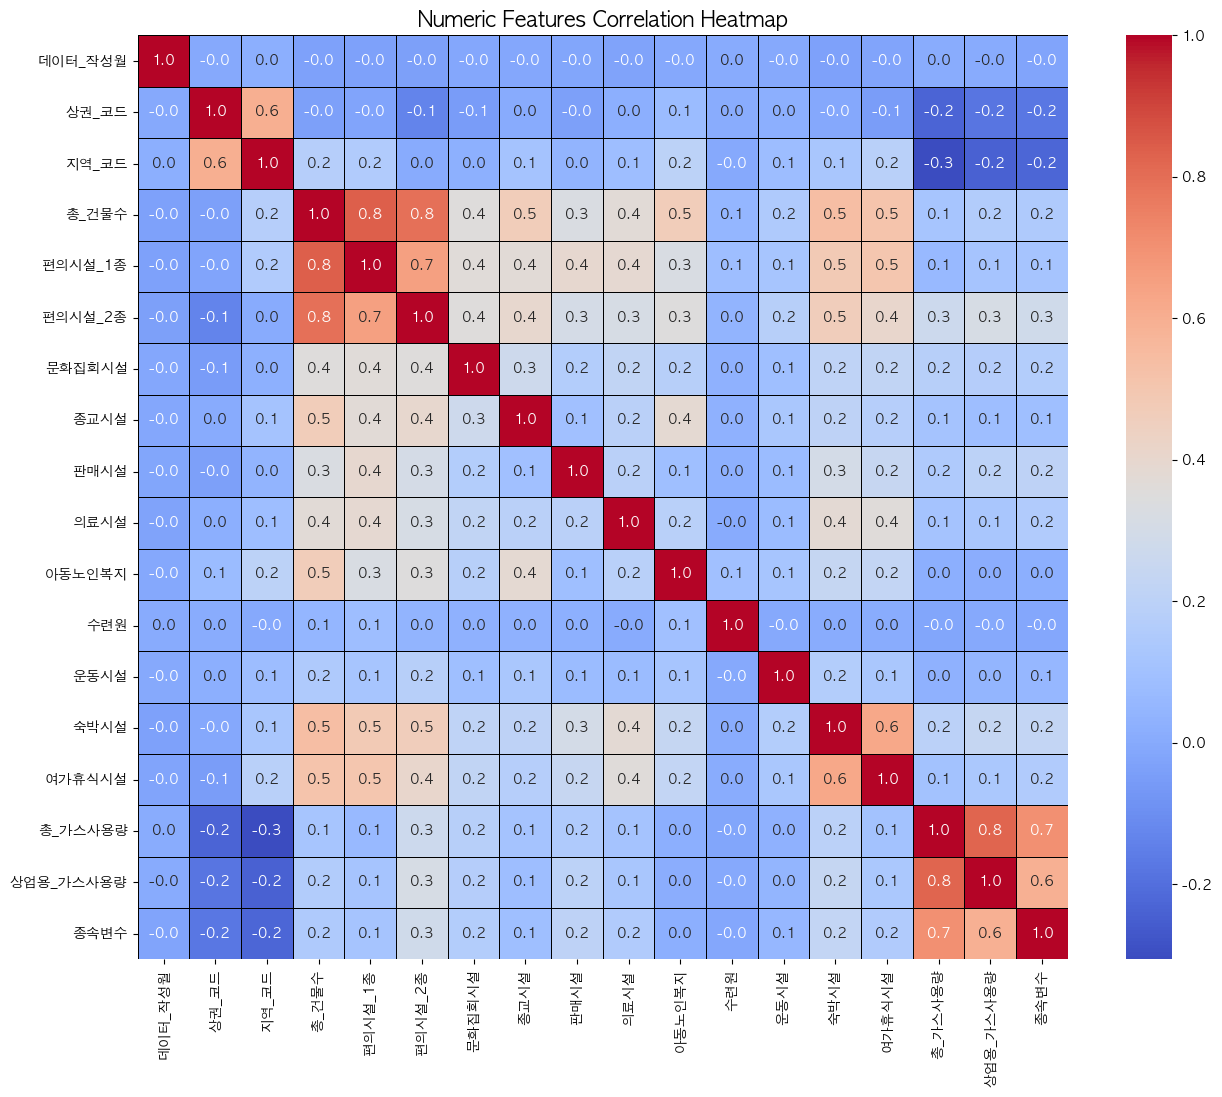

In [17]:
# 숫자형 컬럼 상관계수 계산
corr_matrix = df.corr(numeric_only=True)

# 히트맵 그리기
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix,
                annot=True,      
                cmap='coolwarm', 
                fmt='.1f',       
                linewidths=.5,   
                linecolor='black')
plt.title('Numeric Features Correlation Heatmap', fontsize=15)
plt.show()

In [18]:
# TOTAL_ELEC와의 상관관계만 보기
print("\n종속변수와 상관관계:")
print(corr_matrix['종속변수'].sort_values(ascending=False))


종속변수와 상관관계:
종속변수         1.000000
총_가스사용량      0.702201
상업용_가스사용량    0.596295
편의시설_2종      0.282686
숙박시설         0.226324
판매시설         0.206843
문화집회시설       0.166303
의료시설         0.154966
여가휴식시설       0.153839
총_건물수        0.151882
편의시설_1종      0.115979
종교시설         0.090325
운동시설         0.054920
아동노인복지       0.018961
수련원         -0.013278
데이터_작성월     -0.024666
상권_코드       -0.176933
지역_코드       -0.225352
Name: 종속변수, dtype: float64


In [19]:
# 1. 영어 컬럼명 -> 한글 컬럼명 매핑 딕셔너리 정의
column_rename_dict = {
    'DATA_YM': '데이터_작성월',
    'AREA_ID': '상권_코드',
    'AREA_NM': '상권_명칭',
    'DIST_CD': '지역_코드',
    'DIST_NM': '지역_명칭',
    'TOTAL_BIDG': '총_건물수',
    'FAC_NEIGH_1': '편의시설_1종',
    'FAC_NEIGH_2': '편의시설_2종',
    'FAC_CULT_MTG': '문화집회시설',
    'FAC_RELG': '종교시설',
    'FAC_RETAIL': '판매시설',
    'FAC_MEDI': '의료시설',
    'FAC_YOSE': '아동노인복지',
    'FAC_TRAIN': '수련원',
    'FAC_SPORT': '운동시설',
    'FAC_STAY': '숙박시설',
    'FAC_LEISURE': '여가휴식시설',
    'TOTAL_GAS': '총_가스사용량',
    'CMRC_GAS': '상업용_가스사용량',
    'TOTAL_ELEC': '종속변수' 
}

try:
    # 2. DataFrame 컬럼명 변경 적용
    df.rename(columns=column_rename_dict, inplace=True)

    # 3. 변경된 컬럼명 확인
    print("컬럼명이 한글로 변경되었습니다.")
    print("변경된 컬럼 목록:")
    print(df.columns)

    # print("\n변경된 데이터 미리보기 (첫 5행):")
    # print(df.head())

except NameError:
    print("오류: DataFrame 'df'가 정의되지 않았습니다.")
    print("먼저 데이터를 DataFrame으로 로드했는지 확인해주세요.")
except Exception as e:
    print(f"컬럼명 변경 중 오류 발생: {e}")

컬럼명이 한글로 변경되었습니다.
변경된 컬럼 목록:
Index(['데이터_작성월', '상권_코드', '상권_명칭', '지역_코드', '지역_명칭', '총_건물수', '편의시설_1종',
       '편의시설_2종', '문화집회시설', '종교시설', '판매시설', '의료시설', '아동노인복지', '수련원', '운동시설',
       '숙박시설', '여가휴식시설', '총_가스사용량', '상업용_가스사용량', '종속변수'],
      dtype='object')


In [20]:
df.head()

,데이터_작성월,상권_코드,상권_명칭,지역_코드,지역_명칭,총_건물수,편의시설_1종,편의시설_2종,문화집회시설,종교시설,판매시설,의료시설,아동노인복지,수련원,운동시설,숙박시설,여가휴식시설,총_가스사용량,상업용_가스사용량,종속변수
0,202303,9626,중앙로역_4,27110,중구,538.0,266.0,88.0,6.0,3.0,2.0,3.0,0.0,0.0,0.0,16.0,3.0,517520,466070,1174.570
1,202303,10350,황리단길,47130,경주시,765.0,72.0,174.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,322681,318143,571.137
2,202212,9547,농소1동,31200,북구,343.0,74.0,161.0,1.0,3.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,921843,726861,1094.982
3,202312,9995,심석고등학교,41360,남양주시,129.0,4.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226095,223952,594.064
4,202301,9248,고덕역,11740,강동구,34.0,2.0,14.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1884854,886279,2708.273


탐색된 숫자형 컬럼 (18개): ['데이터_작성월', '상권_코드', '지역_코드', '총_건물수', '편의시설_1종', '편의시설_2종', '문화집회시설', '종교시설', '판매시설', '의료시설', '아동노인복지', '수련원', '운동시설', '숙박시설', '여가휴식시설', '총_가스사용량', '상업용_가스사용량', '종속변수']
다음 15개 숫자형 컬럼의 분포를 시각화합니다: ['총_건물수', '편의시설_1종', '편의시설_2종', '문화집회시설', '종교시설', '판매시설', '의료시설', '아동노인복지', '수련원', '운동시설', '숙박시설', '여가휴식시설', '총_가스사용량', '상업용_가스사용량', '종속변수']
--------------------------------------------------
'총_건물수' 컬럼 분포 시각화 중...


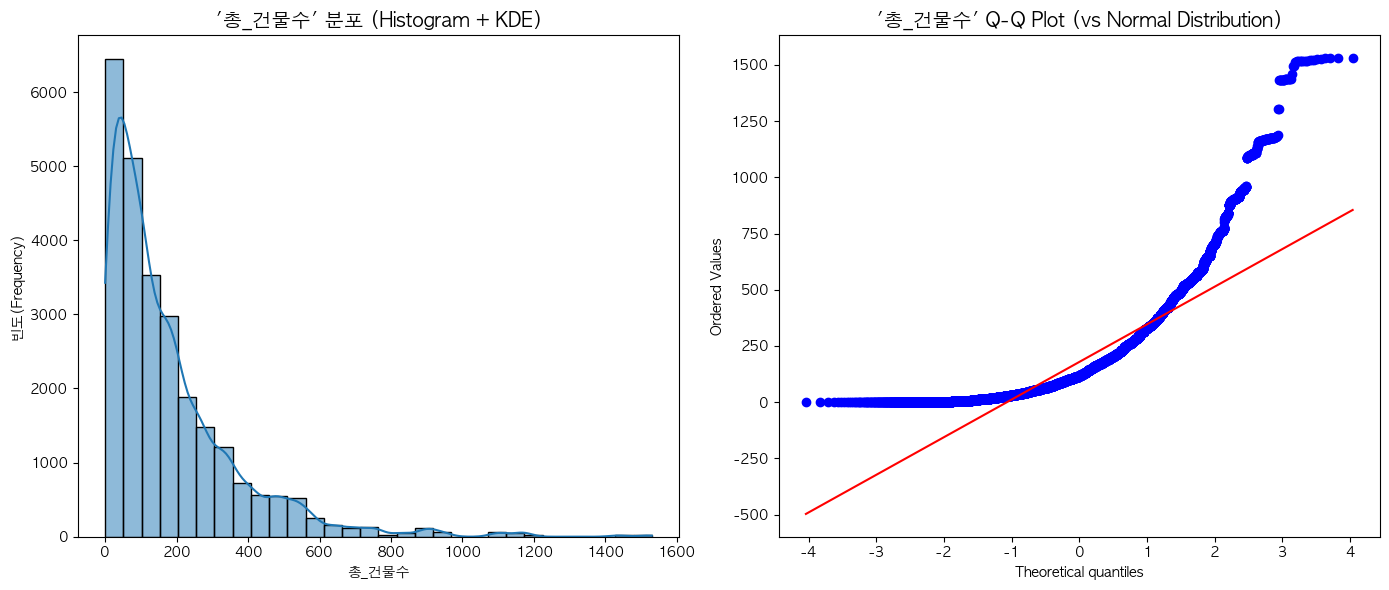

--------------------------------------------------
'편의시설_1종' 컬럼 분포 시각화 중...


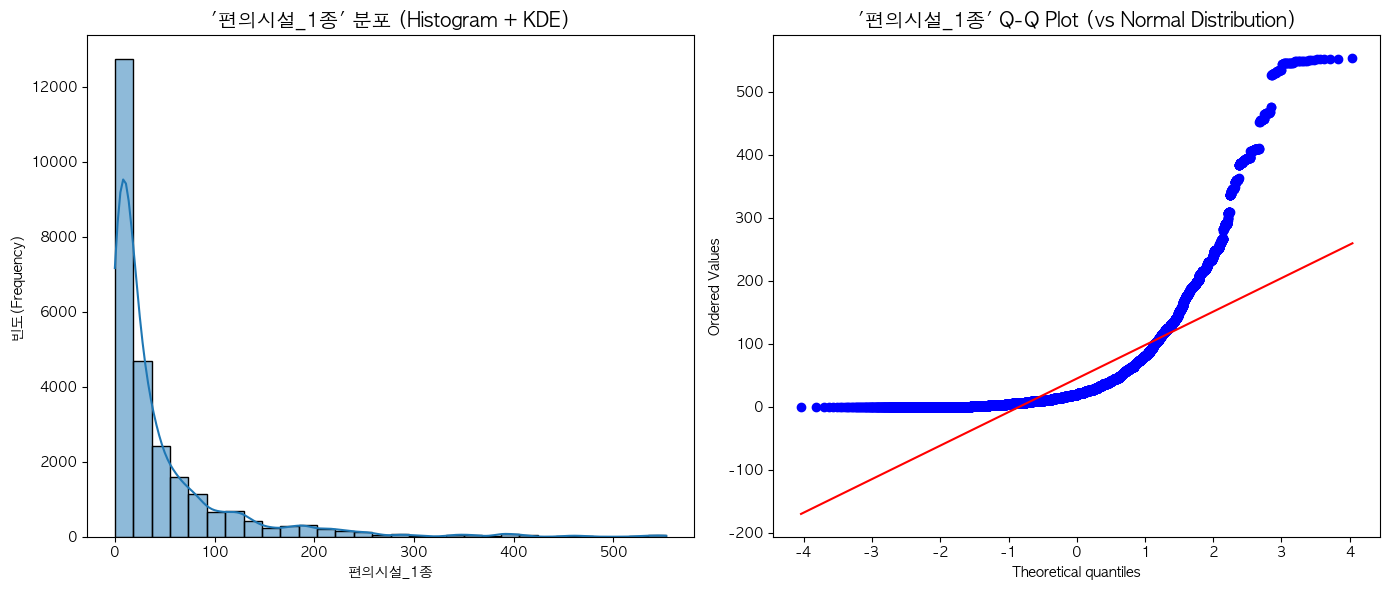

--------------------------------------------------
'편의시설_2종' 컬럼 분포 시각화 중...


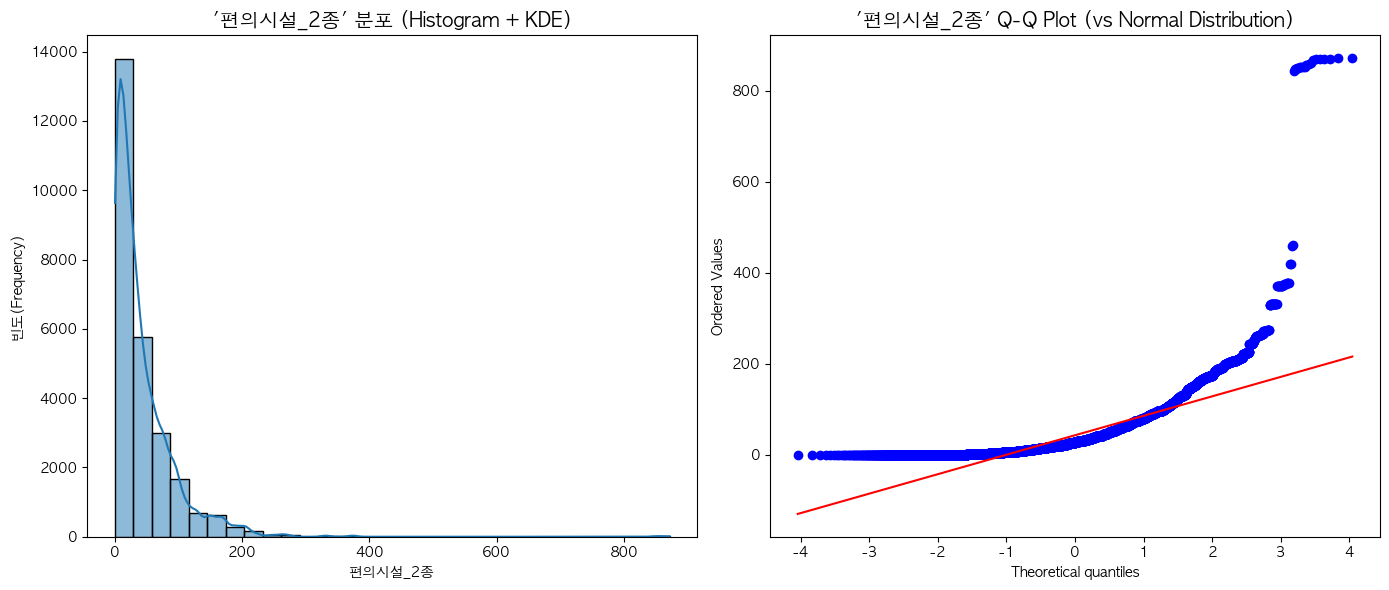

--------------------------------------------------
'문화집회시설' 컬럼 분포 시각화 중...


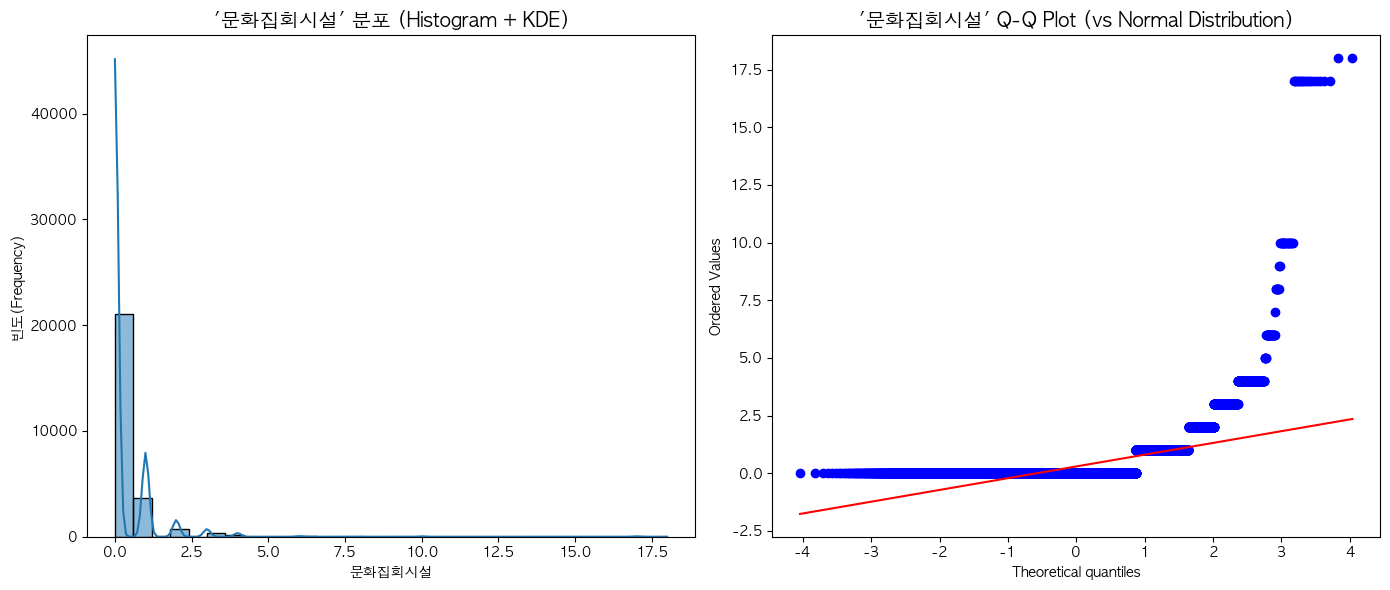

--------------------------------------------------
'종교시설' 컬럼 분포 시각화 중...


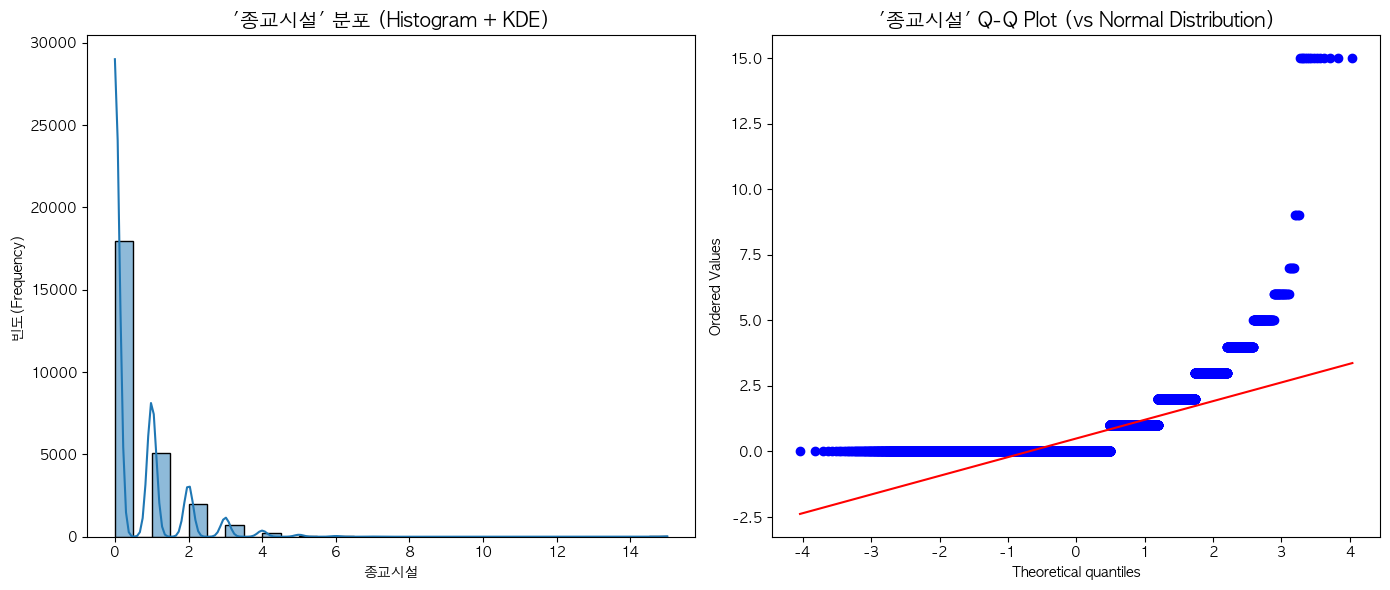

--------------------------------------------------
'판매시설' 컬럼 분포 시각화 중...


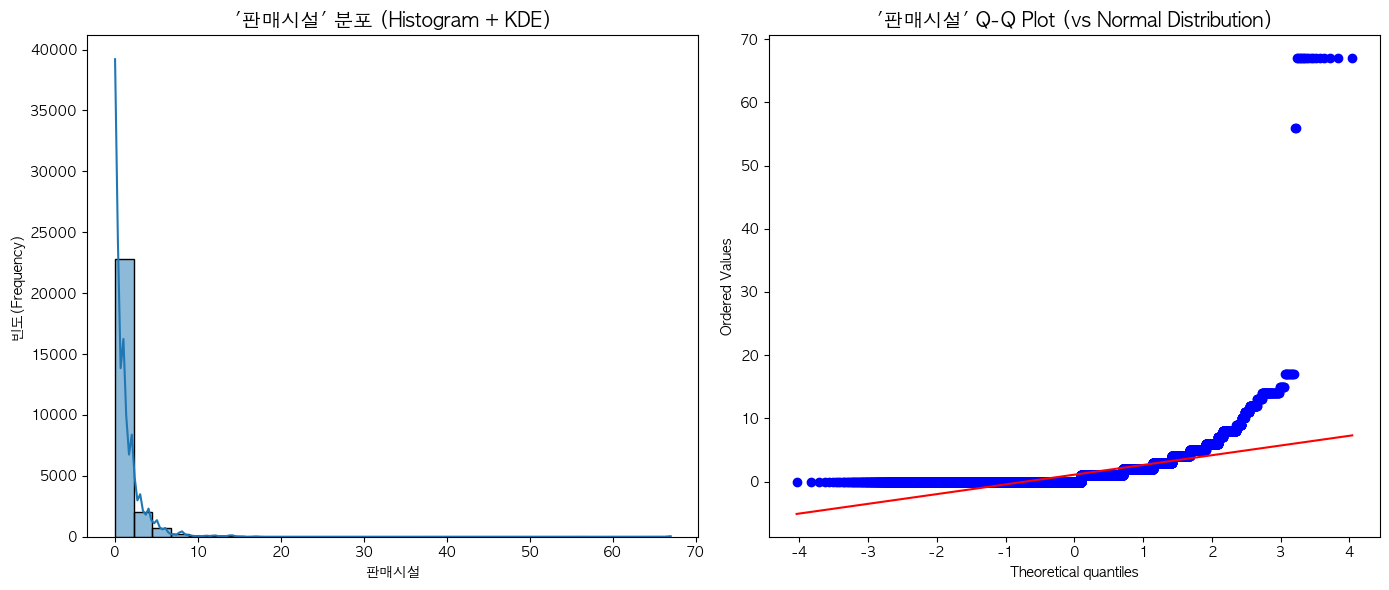

--------------------------------------------------
'의료시설' 컬럼 분포 시각화 중...


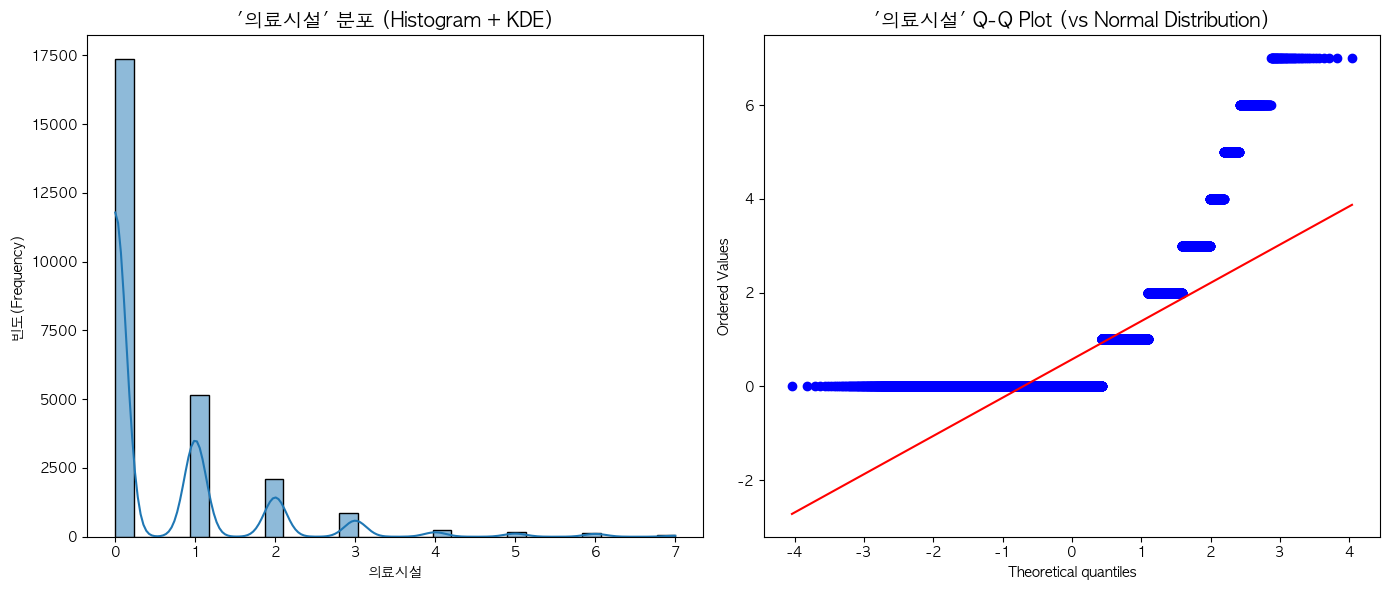

--------------------------------------------------
'아동노인복지' 컬럼 분포 시각화 중...


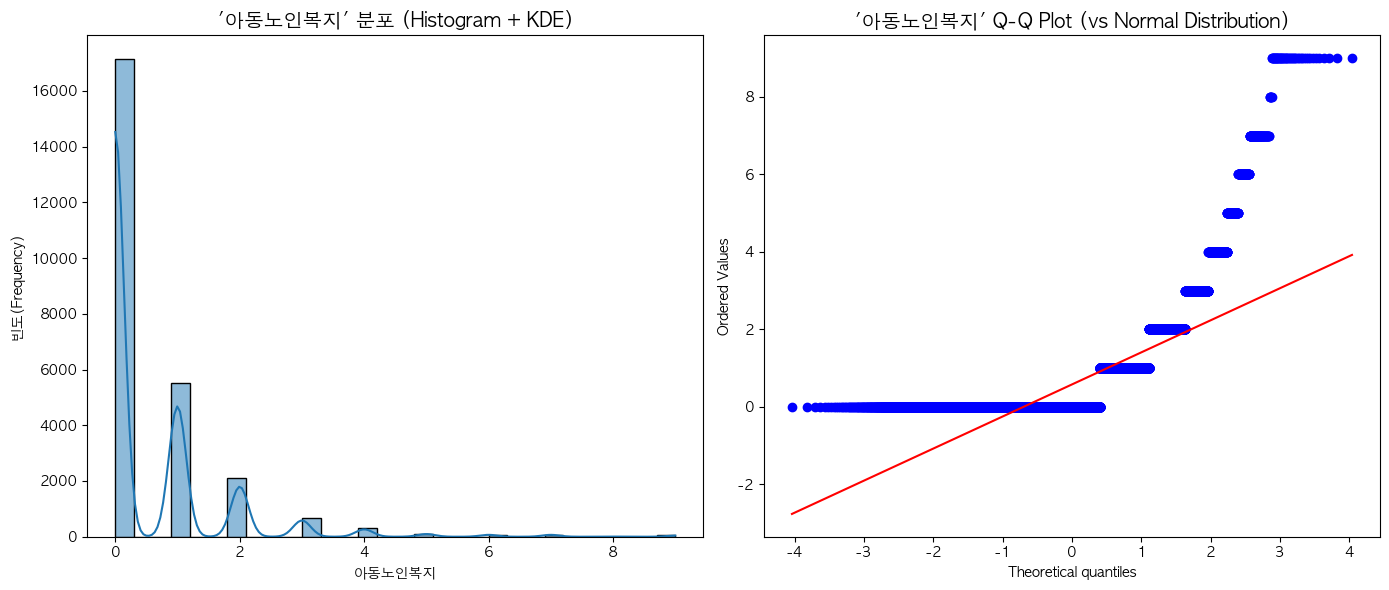

--------------------------------------------------
'수련원' 컬럼 분포 시각화 중...


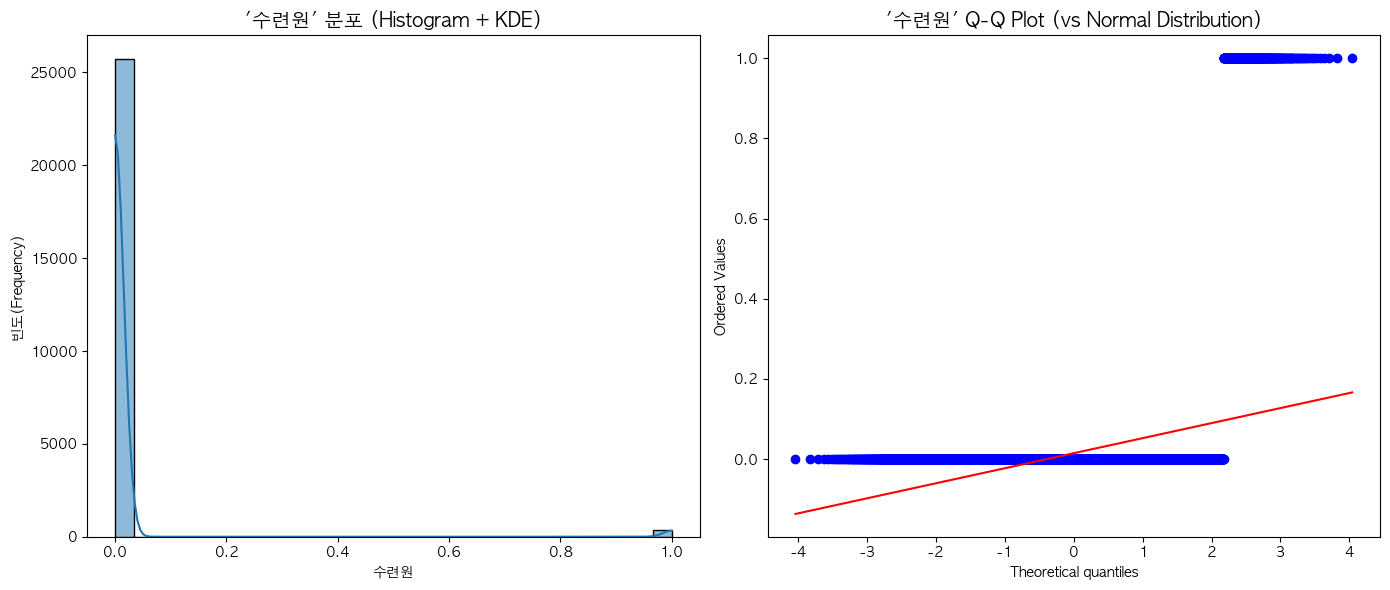

--------------------------------------------------
'운동시설' 컬럼 분포 시각화 중...


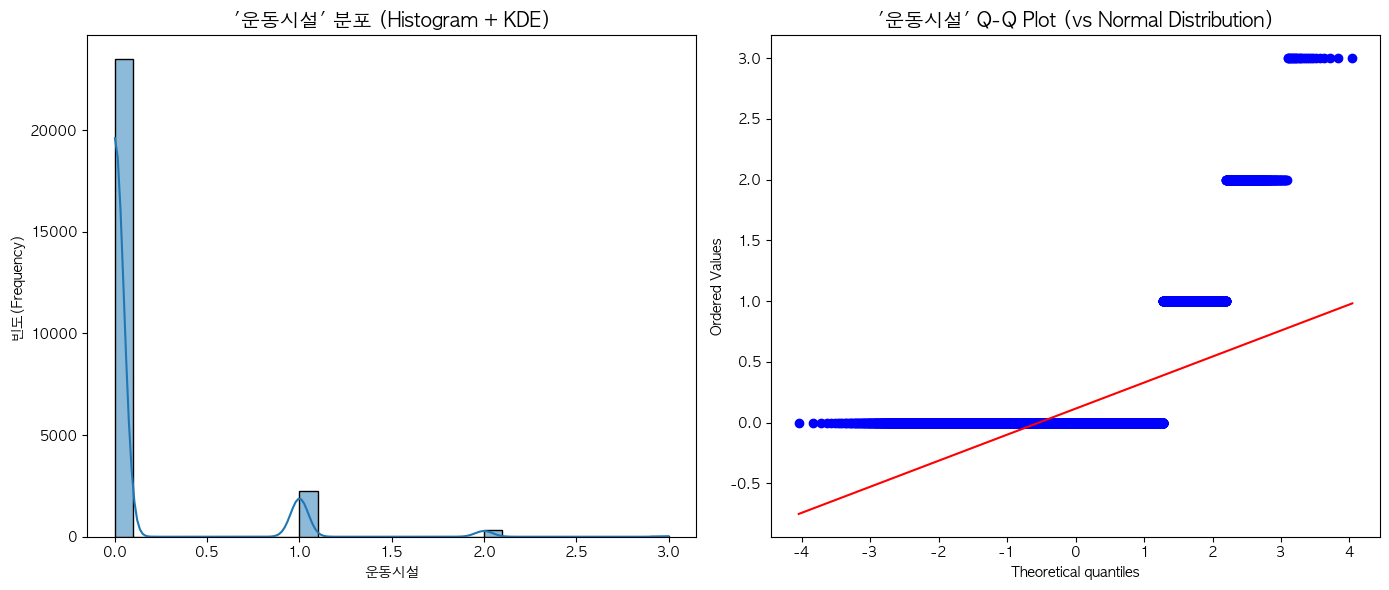

--------------------------------------------------
'숙박시설' 컬럼 분포 시각화 중...


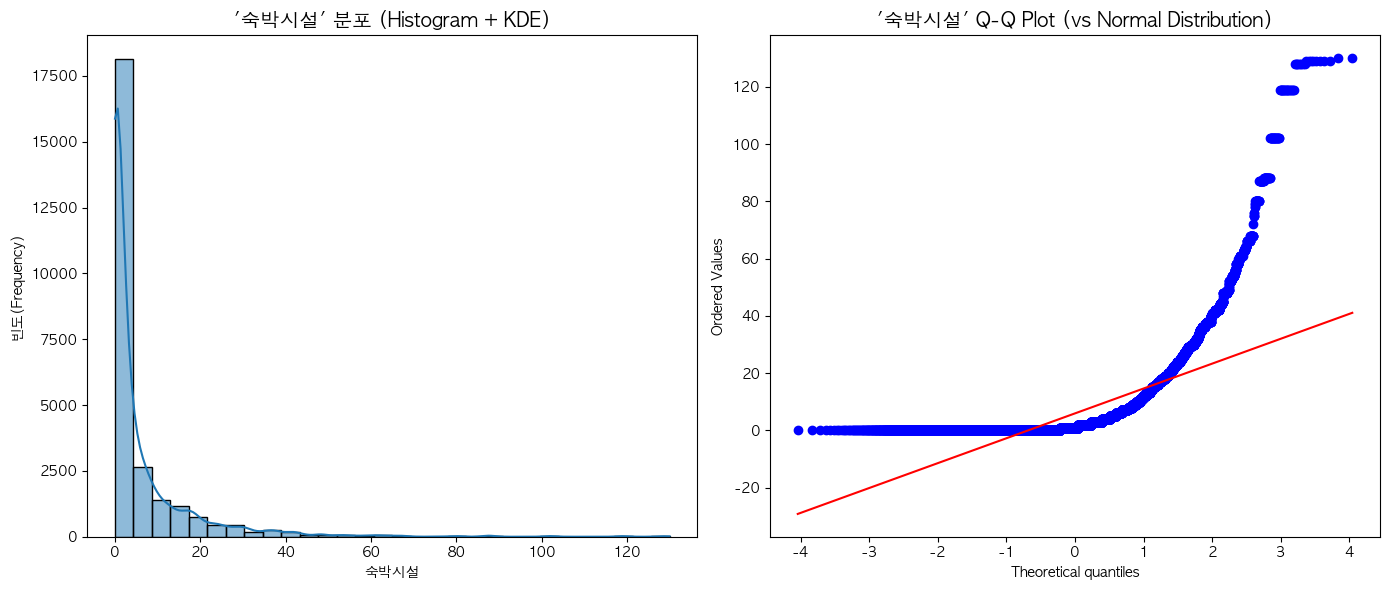

--------------------------------------------------
'여가휴식시설' 컬럼 분포 시각화 중...


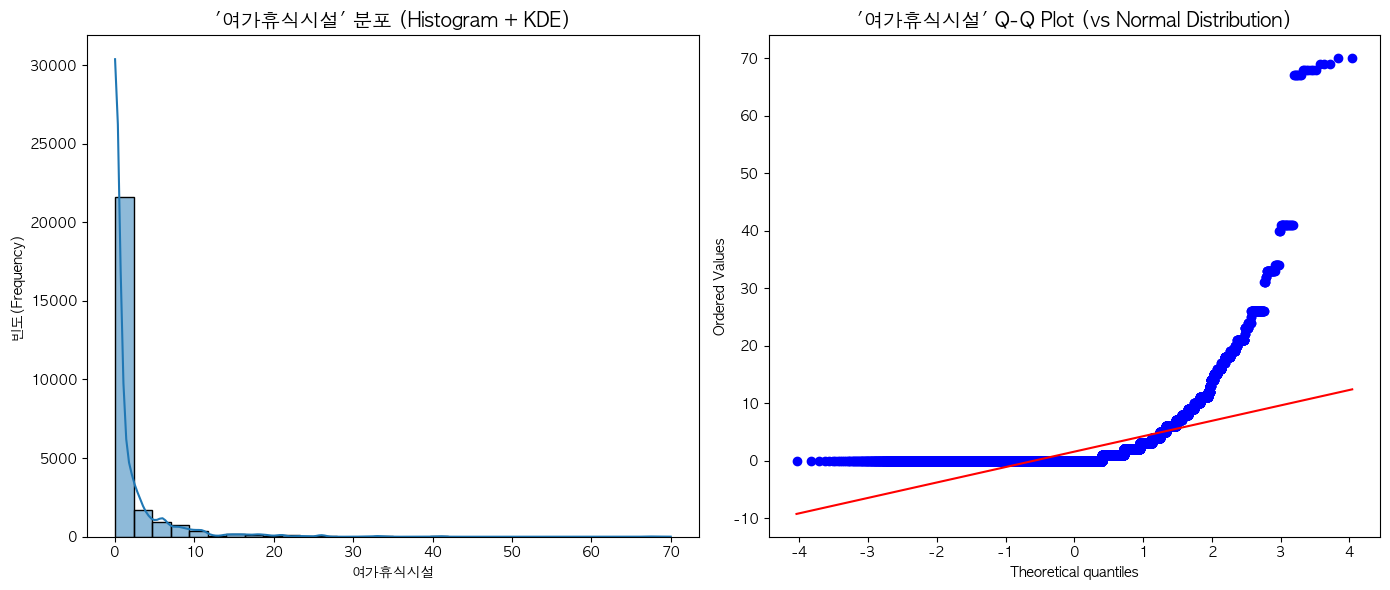

--------------------------------------------------
'총_가스사용량' 컬럼 분포 시각화 중...


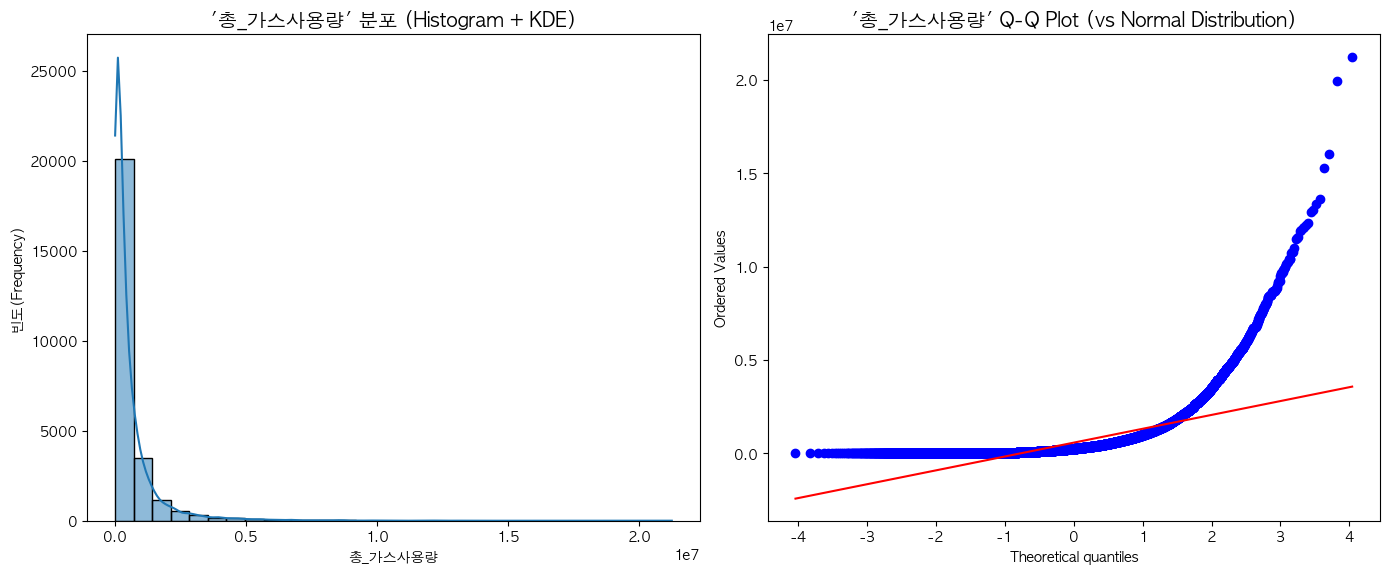

--------------------------------------------------
'상업용_가스사용량' 컬럼 분포 시각화 중...


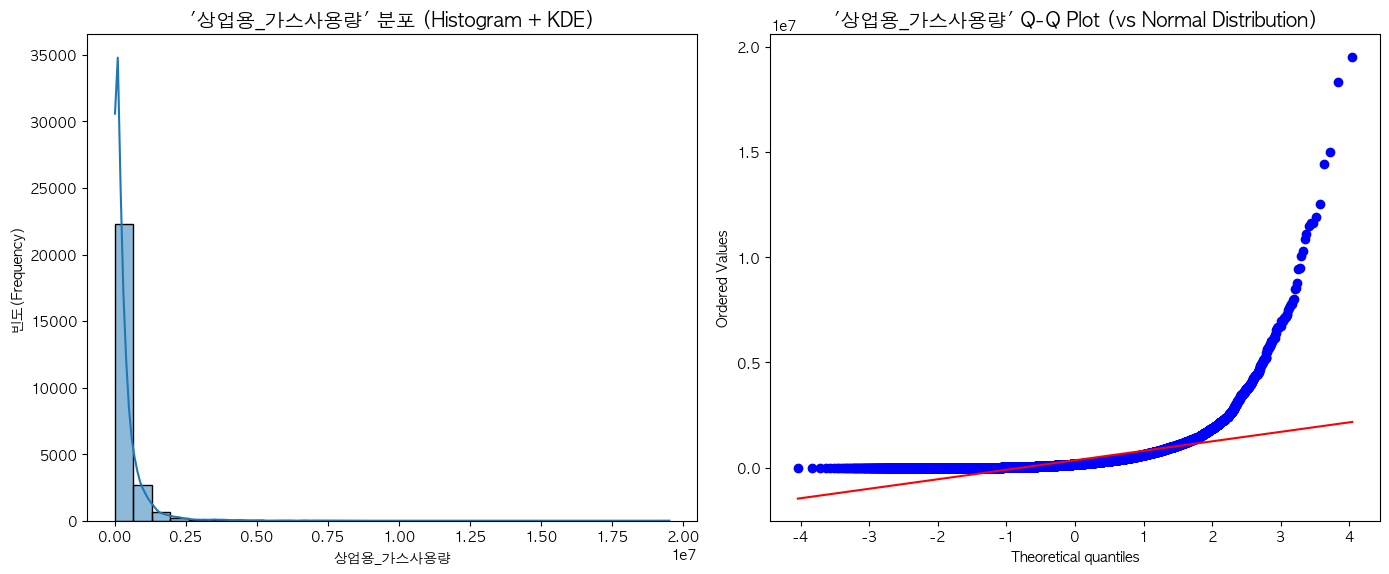

--------------------------------------------------
'종속변수' 컬럼 분포 시각화 중...


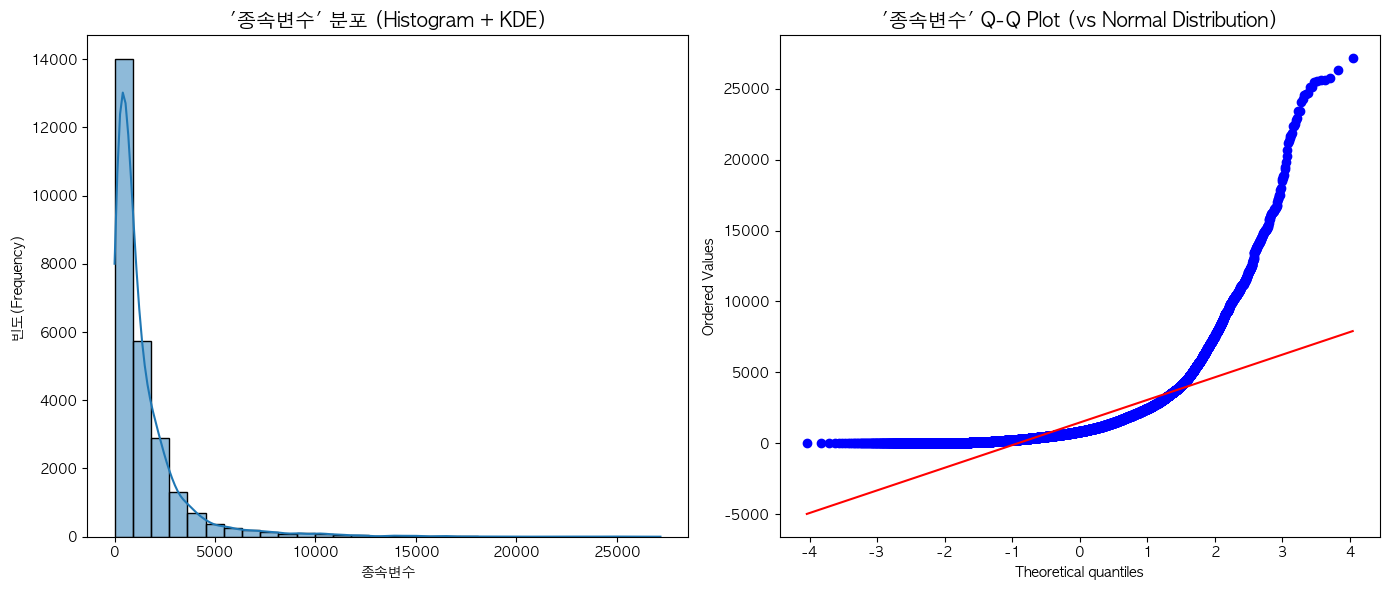

--------------------------------------------------
모든 선택된 숫자형 컬럼의 분포 시각화 완료.


In [21]:
# 1. 모든 숫자형(int, float) 컬럼 이름 가져오기 (df.info() 기준)
all_numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
print(f"탐색된 숫자형 컬럼 ({len(all_numeric_cols)}개): {all_numeric_cols}")

# 2. 분포 확인에서 제외할 ID성 또는 시계열 컬럼 지정 (df.info() 기준 컬럼명)
cols_to_exclude = ['상권_코드', '지역_코드', '데이터_작성월']
numeric_cols_to_plot = [col for col in all_numeric_cols if col not in cols_to_exclude]

if not numeric_cols_to_plot:
    print("오류: 분포를 시각화할 숫자형 컬럼(ID 제외)을 찾을 수 없습니다.")
else:
    # 총 18개 숫자형 컬럼 중 3개 제외 -> 15개 컬럼 시각화
    print(f"다음 {len(numeric_cols_to_plot)}개 숫자형 컬럼의 분포를 시각화합니다: {numeric_cols_to_plot}")
    print("-" * 50)

    # 3. 선택된 각 숫자형 컬럼에 대해 분포 시각화
    for col in numeric_cols_to_plot:
        # 컬럼 내 고유값이 1개 이하인 경우 (모든 값이 같음) 분포 그리기 스킵
        if df[col].nunique() <= 1:
            print(f"'{col}' 컬럼은 고유값이 1개 이하이므로 분포를 그리지 않습니다.")
            print("-" * 50)
            continue

        print(f"'{col}' 컬럼 분포 시각화 중...")
        plt.figure(figsize=(14, 6))

        # Subplot 1: 히스토그램 + KDE
        plt.subplot(1, 2, 1)
        try:
            # bins=30은 막대 개수 조절 옵션, 필요시 변경 가능
            sns.histplot(df[col], kde=True, bins=30)
            plt.title(f'\'{col}\' 분포 (Histogram + KDE)', fontsize=14)
            plt.xlabel(col)
            plt.ylabel('빈도(Frequency)')
        except Exception as e_hist:
            plt.title(f'\'{col}\' Histogram Error', fontsize=14)
            print(f"  - 히스토그램 생성 중 오류: {e_hist}")

        # Subplot 2: Q-Q Plot
        plt.subplot(1, 2, 2)
        try:
            # df.info()에서 non-null 확인했으므로 dropna()는 추가 안전장치
            stats.probplot(df[col].dropna(), dist="norm", plot=plt)
            plt.title(f'\'{col}\' Q-Q Plot (vs Normal Distribution)', fontsize=14)
        except Exception as e_qq:
             plt.title(f'\'{col}\' Q-Q Plot Error', fontsize=14)
             print(f"  - Q-Q 플롯 생성 중 오류: {e_qq}")

        plt.tight_layout() # 그래프 간격 자동 조절
        plt.show()
        print("-" * 50)

    print("모든 선택된 숫자형 컬럼의 분포 시각화 완료.")

다음 컬럼에 로그 변환(log1p)을 적용합니다: ['총_건물수', '편의시설_1종', '편의시설_2종', '종속변수', '상업용_가스사용량', '총_가스사용량', '숙박시설', '여가휴식시설']
--------------------------------------------------
'총_건물수' 컬럼 -> '총_건물수_log' 컬럼으로 로그 변환 완료.
'편의시설_1종' 컬럼 -> '편의시설_1종_log' 컬럼으로 로그 변환 완료.
'편의시설_2종' 컬럼 -> '편의시설_2종_log' 컬럼으로 로그 변환 완료.
'종속변수' 컬럼 -> '종속변수_log' 컬럼으로 로그 변환 완료.
'상업용_가스사용량' 컬럼 -> '상업용_가스사용량_log' 컬럼으로 로그 변환 완료.
'총_가스사용량' 컬럼 -> '총_가스사용량_log' 컬럼으로 로그 변환 완료.
'숙박시설' 컬럼 -> '숙박시설_log' 컬럼으로 로그 변환 완료.
'여가휴식시설' 컬럼 -> '여가휴식시설_log' 컬럼으로 로그 변환 완료.
--------------------------------------------------
로그 변환된 다음 컬럼들의 분포를 시각화합니다: ['총_건물수_log', '편의시설_1종_log', '편의시설_2종_log', '종속변수_log', '상업용_가스사용량_log', '총_가스사용량_log', '숙박시설_log', '여가휴식시설_log']
--------------------------------------------------
'총_건물수_log' (원본: '총_건물수') 컬럼 분포 시각화 중...


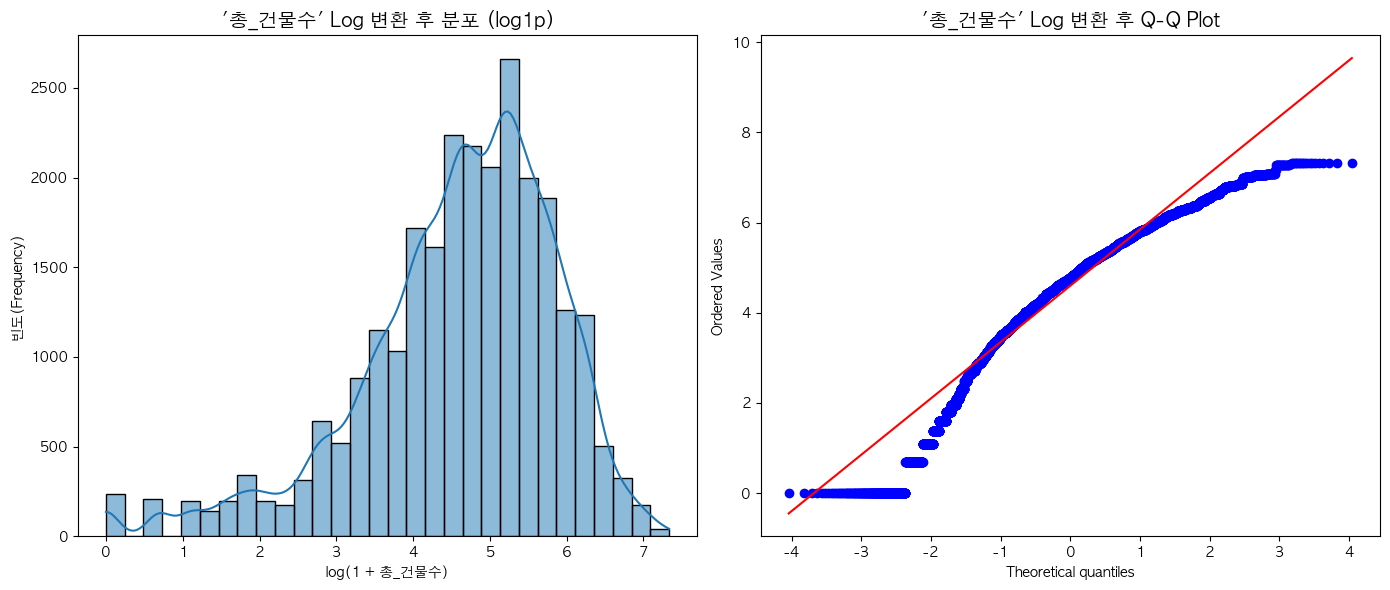

--------------------------------------------------
'편의시설_1종_log' (원본: '편의시설_1종') 컬럼 분포 시각화 중...


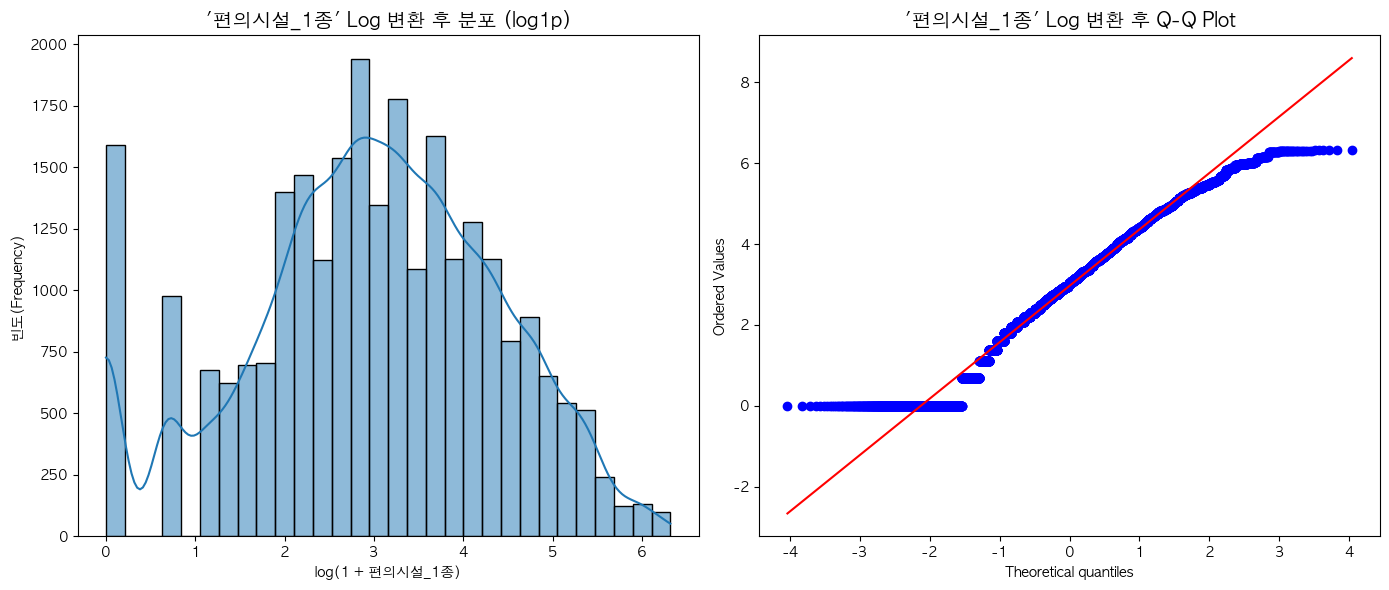

--------------------------------------------------
'편의시설_2종_log' (원본: '편의시설_2종') 컬럼 분포 시각화 중...


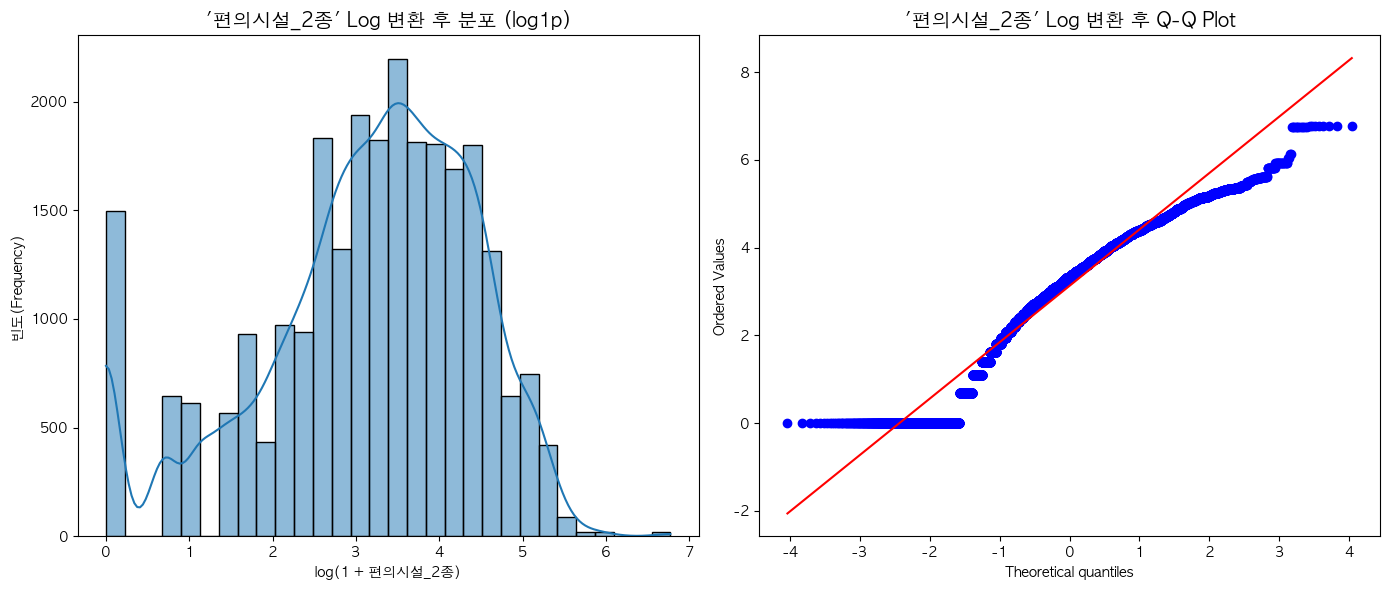

--------------------------------------------------
'종속변수_log' (원본: '종속변수') 컬럼 분포 시각화 중...


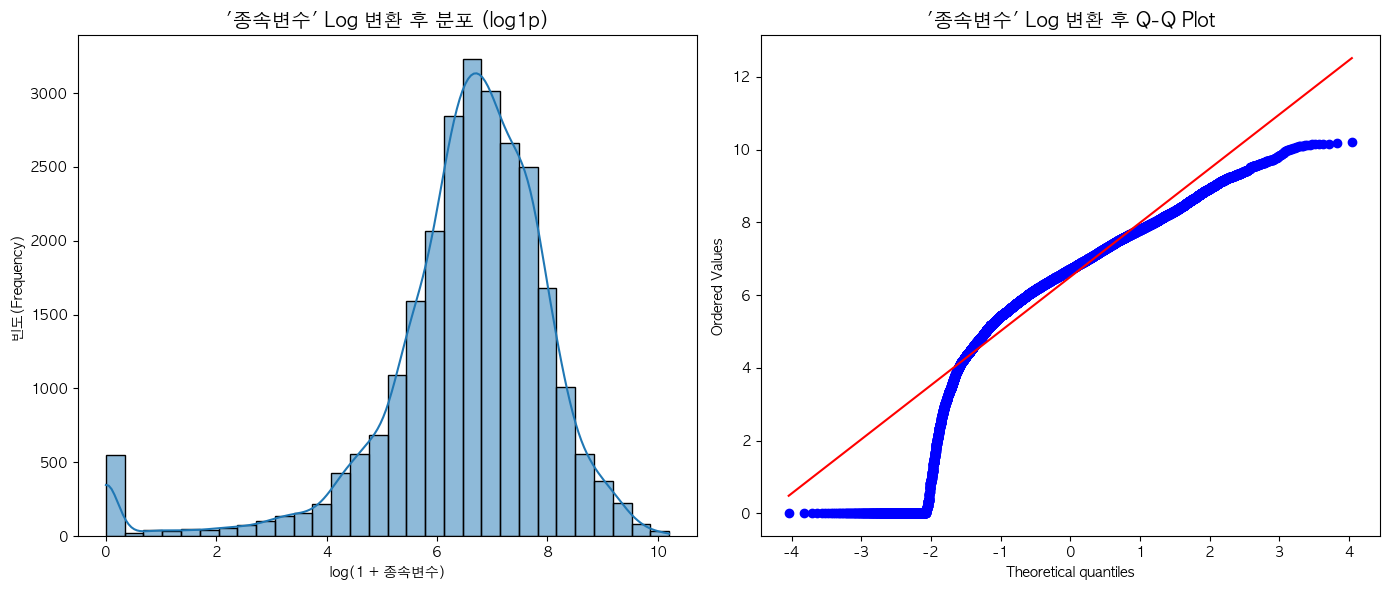

--------------------------------------------------
'상업용_가스사용량_log' (원본: '상업용_가스사용량') 컬럼 분포 시각화 중...


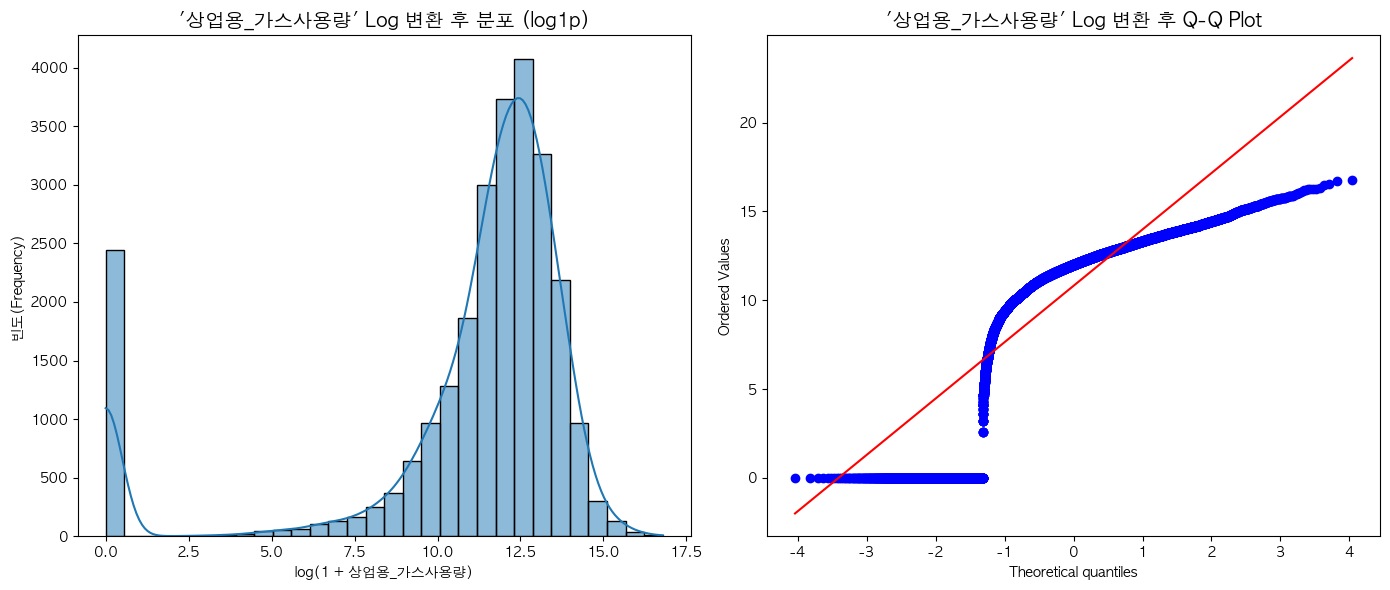

--------------------------------------------------
'총_가스사용량_log' (원본: '총_가스사용량') 컬럼 분포 시각화 중...


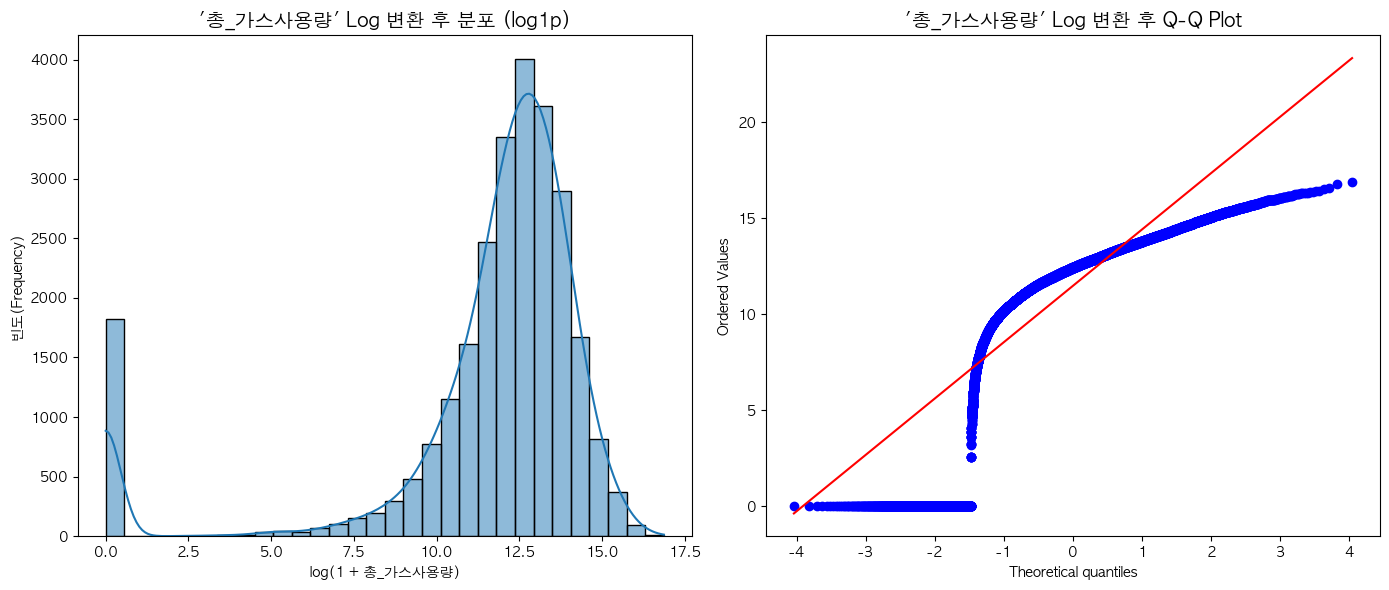

--------------------------------------------------
'숙박시설_log' (원본: '숙박시설') 컬럼 분포 시각화 중...


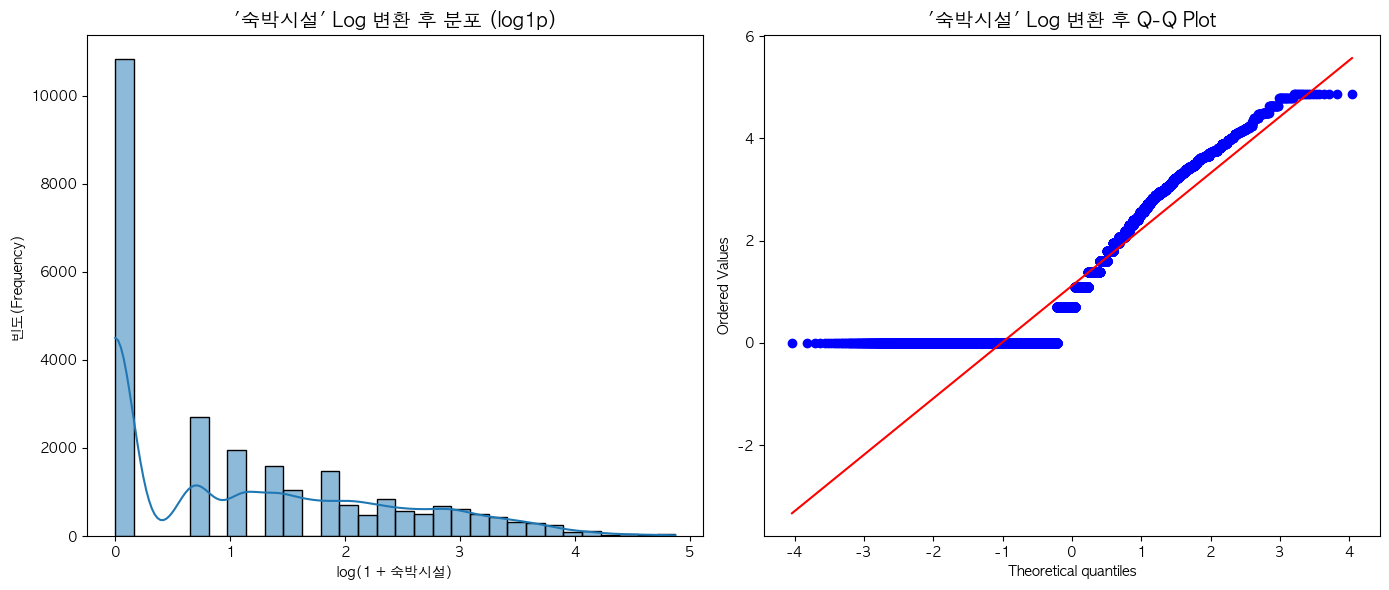

--------------------------------------------------
'여가휴식시설_log' (원본: '여가휴식시설') 컬럼 분포 시각화 중...


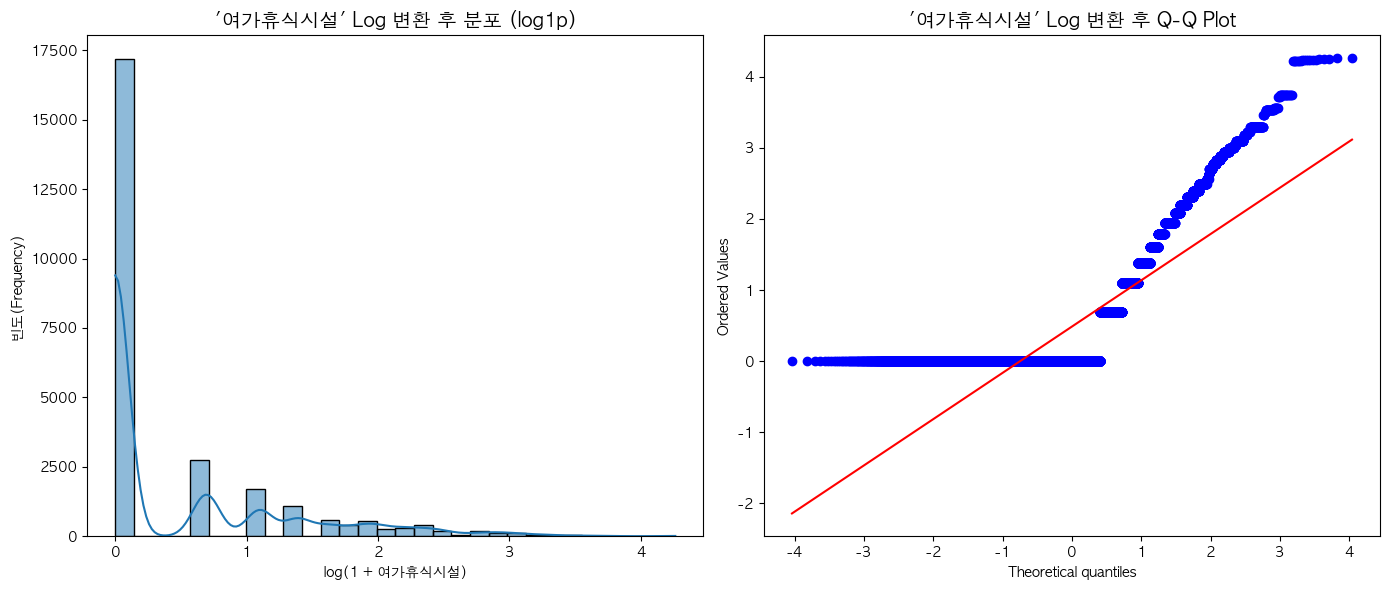

--------------------------------------------------
로그 변환된 컬럼들의 분포 시각화 완료.


In [22]:
# 1. ★ 사용자가 지정한 로그 변환(log1p) 적용 대상 컬럼 목록 ★
cols_to_log_transform = [
    '총_건물수',
    '편의시설_1종', 
    '편의시설_2종', 
    '종속변수',
    '상업용_가스사용량',
    '총_가스사용량',
    '숙박시설',
    '여가휴식시설'
]

# df에 실제 존재하는 컬럼만 필터링
cols_to_log_transform = [col for col in cols_to_log_transform if col in df.columns]
transformed_col_names = [] # 변환된 새 컬럼 이름 저장

if not cols_to_log_transform:
    print("경고: 로그 변환을 적용할 유효한 컬럼이 목록에 없습니다. 컬럼명을 확인하세요.")
else:
    print(f"다음 컬럼에 로그 변환(log1p)을 적용합니다: {cols_to_log_transform}")
    print("-" * 50)

    # 2. 로그 변환 적용 및 새 컬럼 생성 ('_log' 접미사 추가)
    for col in cols_to_log_transform:
        new_col_name = f"{col}_log"
        try:
            if (df[col] < 0).any():
                 print(f"경고: '{col}' 컬럼에 음수 값이 있어 로그 변환(log1p)을 적용할 수 없습니다. 건너<0xEB>뜁니다.")
                 continue

            df[new_col_name] = np.log1p(df[col])
            transformed_col_names.append(new_col_name)
            print(f"'{col}' 컬럼 -> '{new_col_name}' 컬럼으로 로그 변환 완료.")

        except Exception as e:
            print(f"'{col}' 컬럼 로그 변환 중 오류 발생: {e}")

    print("-" * 50)

    # 3. 로그 변환된 컬럼들의 분포 시각화 
    if not transformed_col_names:
        print("로그 변환된 컬럼이 없어 시각화를 진행할 수 없습니다.")
    else:
        print(f"로그 변환된 다음 컬럼들의 분포를 시각화합니다: {transformed_col_names}")
        print("-" * 50)

        for col_log in transformed_col_names:
            original_col = col_log.replace('_log', '')

            if df[col_log].nunique(dropna=False) <= 1:
                print(f"'{col_log}' 컬럼은 고유값이 1개 이하이므로 분포를 그리지 않습니다.")
                print("-" * 50)
                continue

            print(f"'{col_log}' (원본: '{original_col}') 컬럼 분포 시각화 중...")
            plt.figure(figsize=(14, 6))

            # Subplot 1: 히스토그램 + KDE
            plt.subplot(1, 2, 1)
            try:
                sns.histplot(df[col_log], kde=True, bins=30)
                plt.title(f'\'{original_col}\' Log 변환 후 분포 (log1p)', fontsize=14)
                plt.xlabel(f'log(1 + {original_col})')
                plt.ylabel('빈도(Frequency)')
            except Exception as e_hist:
                plt.title(f'\'{col_log}\' Histogram Error', fontsize=14)
                print(f"  - 히스토그램 생성 중 오류: {e_hist}")

            # Subplot 2: Q-Q Plot
            plt.subplot(1, 2, 2)
            try:
                stats.probplot(df[col_log].dropna(), dist="norm", plot=plt)
                plt.title(f'\'{original_col}\' Log 변환 후 Q-Q Plot', fontsize=14)
            except Exception as e_qq:
                 plt.title(f'\'{col_log}\' Q-Q Plot Error', fontsize=14)
                 print(f"  - Q-Q 플롯 생성 중 오류: {e_qq}")

            plt.tight_layout()
            plt.show()
            print("-" * 50)

        print("로그 변환된 컬럼들의 분포 시각화 완료.")

In [23]:
df.head()

,데이터_작성월,상권_코드,상권_명칭,지역_코드,지역_명칭,총_건물수,편의시설_1종,편의시설_2종,문화집회시설,종교시설,...,상업용_가스사용량,종속변수,총_건물수_log,편의시설_1종_log,편의시설_2종_log,종속변수_log,상업용_가스사용량_log,총_가스사용량_log,숙박시설_log,여가휴식시설_log
0,202303,9626,중앙로역_4,27110,중구,538.0,266.0,88.0,6.0,3.0,...,466070,1174.570,6.289716,5.587249,4.488636,7.069508,13.052093,13.156805,2.833213,1.386294
1,202303,10350,황리단길,47130,경주시,765.0,72.0,174.0,1.0,0.0,...,318143,571.137,6.641182,4.290459,5.164786,6.349378,12.670259,12.684423,1.098612,0.000000
2,202212,9547,농소1동,31200,북구,343.0,74.0,161.0,1.0,3.0,...,726861,1094.982,5.840642,4.317488,5.087596,6.999406,13.496492,13.734131,0.000000,0.000000
3,202312,9995,심석고등학교,41360,남양주시,129.0,4.0,14.0,0.0,1.0,...,223952,594.064,4.867534,1.609438,2.708050,6.388669,12.319191,12.328715,0.000000,0.000000
4,202301,9248,고덕역,11740,강동구,34.0,2.0,14.0,0.0,0.0,...,886279,2708.273,3.555348,1.098612,2.708050,7.904436,13.694788,14.449361,0.000000,0.000000


In [24]:
# df: 원본 + 로그 변환된 컬럼(_log)들이 모두 포함된 데이터프레임
# transformed_col_names: 로그 변환된 컬럼명 리스트 (예: ['총_건물수_log', ..., '종속변수_log'])
# cols_to_log_transform: 로그 변환을 적용했던 원본 컬럼명 리스트 (예: ['총_건물수', ..., '종속변수'])
# --------------------------------------------------------------

try:
    # 1. 로그 변환된 예측 변수 식별 (종속 변수 '_log' 버전 제외)
    log_transformed_target_name = '종속변수_log' # 종속 변수도 로그변환 했다고 가정
    log_transformed_predictors = [col for col in transformed_col_names if col != log_transformed_target_name]
    print(f"df2에 포함될 로그 변환된 예측 변수 ({len(log_transformed_predictors)}개): {log_transformed_predictors}")

    # 2. 로그 변환 안 된 다른 숫자형 예측 변수 식별
    original_numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    cols_to_exclude_ids_time = ['상권_코드', '지역_코드', '데이터_작성월'] # 제외할 ID, 시간 컬럼
    original_cols_that_were_logged = cols_to_log_transform # 로그 변환된 원본 컬럼 제외용
    target_col_original = '종속변수' # 원본 종속 변수 제외용

    non_transformed_numeric_predictors = [
        col for col in original_numeric_cols
        if col not in cols_to_exclude_ids_time           # ID/시간 제외
        and col not in original_cols_that_were_logged   # 로그변환된 원본 제외
        and col != target_col_original                  # 원본 종속 제외
        and not col.endswith('_log')                    # 이미 선택된 로그 컬럼 제외(중복 방지)
    ]
    print(f"df2에 포함될 로그 변환 안 된 숫자형 예측 변수 ({len(non_transformed_numeric_predictors)}개): {non_transformed_numeric_predictors}")

    # 3. 두 리스트를 합쳐 최종 예측 변수 목록 생성
    final_predictor_cols_for_df2 = log_transformed_predictors + non_transformed_numeric_predictors
    print(f"\n최종 예측 변수 목록 (총 {len(final_predictor_cols_for_df2)}개): {final_predictor_cols_for_df2}")

    # 4. df2 데이터프레임 생성 (예측 변수만 포함)
    if not final_predictor_cols_for_df2:
         print("오류: df2를 생성할 예측 변수가 없습니다. 컬럼 목록 및 이전 단계를 확인하세요.")
         df2 = pd.DataFrame() # 빈 데이터프레임 생성
    else:
        # .copy()를 사용하여 df 원본과 분리
        df2 = df[final_predictor_cols_for_df2].copy()
        print(f"\n예측 변수만 포함하는 새로운 DataFrame 'df2' 생성 완료!")
        print(f"df2 형태 (행, 열): {df2.shape}")

        # 5. 생성된 df2 확인 (옵션)
        # print("\ndf2 정보:")
        # df2.info()
        # print("\ndf2 상위 5행 미리보기:")
        # print(df2.head())

except NameError as e:
    print(f"오류: 필요한 변수(df, transformed_col_names, cols_to_log_transform)가 정의되지 않았습니다: {e}")
    print("-> 로그 변환을 실행하는 이전 단계 코드가 정상적으로 실행되었는지 확인해주세요.")
    df2 = None # df2 생성 실패 표시
except Exception as e:
    print(f"df2 생성 중 오류 발생: {e}")
    df2 = None # df2 생성 실패 표시

df2에 포함될 로그 변환된 예측 변수 (7개): ['총_건물수_log', '편의시설_1종_log', '편의시설_2종_log', '상업용_가스사용량_log', '총_가스사용량_log', '숙박시설_log', '여가휴식시설_log']
df2에 포함될 로그 변환 안 된 숫자형 예측 변수 (7개): ['문화집회시설', '종교시설', '판매시설', '의료시설', '아동노인복지', '수련원', '운동시설']

최종 예측 변수 목록 (총 14개): ['총_건물수_log', '편의시설_1종_log', '편의시설_2종_log', '상업용_가스사용량_log', '총_가스사용량_log', '숙박시설_log', '여가휴식시설_log', '문화집회시설', '종교시설', '판매시설', '의료시설', '아동노인복지', '수련원', '운동시설']

예측 변수만 포함하는 새로운 DataFrame 'df2' 생성 완료!
df2 형태 (행, 열): (26099, 14)


In [25]:
df2.head()

,총_건물수_log,편의시설_1종_log,편의시설_2종_log,상업용_가스사용량_log,총_가스사용량_log,숙박시설_log,여가휴식시설_log,문화집회시설,종교시설,판매시설,의료시설,아동노인복지,수련원,운동시설
0,6.289716,5.587249,4.488636,13.052093,13.156805,2.833213,1.386294,6.0,3.0,2.0,3.0,0.0,0.0,0.0
1,6.641182,4.290459,5.164786,12.670259,12.684423,1.098612,0.000000,1.0,0.0,2.0,0.0,1.0,0.0,0.0
2,5.840642,4.317488,5.087596,13.496492,13.734131,0.000000,0.000000,1.0,3.0,0.0,2.0,6.0,0.0,0.0
3,4.867534,1.609438,2.708050,12.319191,12.328715,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3.555348,1.098612,2.708050,13.694788,14.449361,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [26]:
try:
    print(f"지역 코드 ('지역_코드') 고유값 개수: {df['지역_코드'].nunique()}")
    print(f"상권 코드 ('상권_명칭') 고유값 개수: {df['상권_명칭'].nunique()}")
    print(f"상권 코드 ('상권_코드') 고유값 개수: {df['상권_코드'].nunique()}")
    print(f"상권 코드 ('지역_명칭') 고유값 개수: {df['지역_명칭'].nunique()}")
    
except KeyError as e:
    print(f"오류: 해당 컬럼({e})을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
except NameError:
    print("오류: DataFrame 'df'가 정의되지 않았습니다.")

지역 코드 ('지역_코드') 고유값 개수: 271
상권 코드 ('상권_명칭') 고유값 개수: 1147
상권 코드 ('상권_코드') 고유값 개수: 1166
상권 코드 ('지역_명칭') 고유값 개수: 220


In [27]:
# df2: 최종 숫자형 예측 변수들만 포함하는 데이터프레임

if 'df2' in locals() and isinstance(df2, pd.DataFrame) and not df2.empty:
    print("df2 (최종 숫자형 예측 변수 세트)를 사용하여 VIF를 계산합니다.")
    print(f"df2 형태: {df2.shape}")
    print(f"VIF 계산 대상 컬럼 ({len(df2.columns)}개): {df2.columns.tolist()}")

    # VIF 계산을 위한 데이터 준비 (df2 사용)
    X_for_vif = df2.copy()

    # VIF 계산 시 NaN이 있으면 오류 발생하므로 확인 및 제거 (이론상 없어야 함)
    if X_for_vif.isnull().sum().any():
        print("경고: VIF 계산 대상 데이터(df2)에 NaN 값이 있습니다. 해당 행을 제거합니다.")
        X_for_vif.dropna(inplace=True)

    # 모든 컬럼이 숫자형인지 최종 확인
    if not all(pd.api.types.is_numeric_dtype(X_for_vif[col]) for col in X_for_vif.columns):
        print("오류: VIF 계산을 위해서는 모든 예측 변수가 숫자형이어야 합니다.")
        print("df2 생성 과정이나 컬럼 선택을 다시 확인해주세요.")
    else:
        # 상수항(intercept) 추가 - VIF 계산 함수의 요구사항
        X_for_vif['intercept'] = 1

        # VIF 계산
        try:
            vif_data = pd.DataFrame()
            # VIF 계산 대상 피처 이름 저장 (intercept 제외)
            vif_data["feature"] = X_for_vif.columns.drop('intercept')
            # 각 피처에 대해 VIF 계산
            vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i)
                               for i in range(X_for_vif.shape[1] - 1)] # intercept 제외

            print("\nVariance Inflation Factor (VIF):")
            # VIF 값이 높은 순서대로 정렬하여 출력
            print(vif_data.sort_values('VIF', ascending=False))

            # VIF 임계값 (일반적으로 5 또는 10) 기준으로 확인
            threshold = 10
            high_vif_features = vif_data[vif_data["VIF"] > threshold]
            if not high_vif_features.empty:
                print(f"\n주의: VIF > {threshold} 인 높은 다중공선성 의심 변수:")
                print(high_vif_features)
            else:
                print(f"\nVIF > {threshold} 인 높은 다중공선성은 발견되지 않았습니다.")

        except Exception as e:
            print(f"\nVIF 계산 중 오류 발생: {e}")
            # 흔한 오류 원인 안내
            print("  - 입력 데이터(df2)에 NaN이 남아있는지 확인하세요.")
            print("  - 예측 변수들 간에 완벽한 선형 관계(하나가 다른 하나의 상수배 등)가 있는지 확인하세요.")

else:
    print("오류: VIF를 계산할 'df2' 데이터프레임이 준비되지 않았습니다.")
    print("-> 이전 단계에서 df2를 생성하는 코드를 먼저 실행해주세요.")

df2 (최종 숫자형 예측 변수 세트)를 사용하여 VIF를 계산합니다.
df2 형태: (26099, 14)
VIF 계산 대상 컬럼 (14개): ['총_건물수_log', '편의시설_1종_log', '편의시설_2종_log', '상업용_가스사용량_log', '총_가스사용량_log', '숙박시설_log', '여가휴식시설_log', '문화집회시설', '종교시설', '판매시설', '의료시설', '아동노인복지', '수련원', '운동시설']

Variance Inflation Factor (VIF):
          feature       VIF
3   상업용_가스사용량_log  5.373567
2     편의시설_2종_log  5.045631
4     총_가스사용량_log  4.912275
0       총_건물수_log  4.684619
1     편의시설_1종_log  4.566965
5        숙박시설_log  2.301665
6      여가휴식시설_log  2.151183
8            종교시설  1.321411
11         아동노인복지  1.304175
10           의료시설  1.273527
7          문화집회시설  1.169998
9            판매시설  1.141366
13           운동시설  1.055644
12            수련원  1.013859

VIF > 10 인 높은 다중공선성은 발견되지 않았습니다.


In [28]:
# df: 원본 + 로그 변환된 컬럼(_log)들이 모두 포함된 데이터프레임
# df2: 최종 숫자형 예측 변수들만 포함하는 데이터프레임 (모델의 입력 X로 사용)

try:
    # 1. 최종 예측 변수(X)와 타겟 변수(y) 정의
    X = df2 # df2 사용
    target_col_log = '종속변수_log' # 로그 변환된 타겟 변수

    if target_col_log not in df.columns:
        raise NameError(f"타겟 변수 '{target_col_log}'가 df에 없습니다. 타겟 변수 로그 변환 단계를 확인하세요.")
    if X.shape[0] != df.shape[0]:
         raise ValueError("X(df2)와 df의 행 수가 다릅니다. 데이터 정렬 상태를 확인하세요.")

    y = df[target_col_log]

    # 행 인덱스 정렬 (안전 장치)
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    print(f"사용될 예측 변수 (X) 형태: {X.shape}")
    print(f"사용될 타겟 변수 (y) 형태: {y.shape}")

    # 2. 학습/검증 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"학습 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}")

    # 3. 특성 스케일링 (StandardScaler 사용) - 예측 변수(X)에만 적용
    scaler = StandardScaler()
    # 학습 데이터 기준으로 scaler 학습(fit) 및 변환(transform)
    X_train_scaled = scaler.fit_transform(X_train)
    # 검증 데이터는 학습된 scaler로 변환만(transform) 적용
    X_val_scaled = scaler.transform(X_val)
    print("예측 변수(Features) 스케일링 완료 (StandardScaler).")

    # 4. 선형 회귀 모델 인스턴스 생성 및 학습
    model = LinearRegression()
    print("선형 회귀 모델 학습 시작...")
    model.fit(X_train_scaled, y_train)
    print("선형 회귀 모델 학습 완료.")

    # 5. 검증 데이터에 대한 예측 수행 (로그 스케일)
    y_pred_log = model.predict(X_val_scaled)
    print("검증 데이터 예측 완료 (로그 스케일).")

    # 6. 예측값 역변환 (로그 스케일 -> 원본 스케일)
    # np.expm1() 함수는 np.log1p()의 역함수 (exp(x) - 1)
    y_pred = np.expm1(y_pred_log)
    # 전기 사용량은 음수가 될 수 없으므로, 0 미만 값은 0으로 처리
    y_pred[y_pred < 0] = 0
    print("예측값을 원본 스케일로 역변환 완료.")

    # 7. 실제 검증 데이터 타겟값 역변환 (로그 스케일 -> 원본 스케일)
    y_val_original = np.expm1(y_val)
    print("실제 검증 타겟값을 원본 스케일로 역변환 완료.")

    # 8. 성능 평가: RMSE (원본 스케일 기준)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_pred))
    print("-" * 50)
    print(f"베이스라인 선형 회귀 모델 성능:")
    print(f"검증 데이터 RMSE (원본 스케일): {rmse:.4f}")
    print("-" * 50)

    # 9. 학습된 회귀 계수 확인
    try:
        # 스케일링된 데이터 기준 계수 확인
        coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
        print("\n모델 회귀 계수 (스케일링된 데이터 기준):")
        # 계수 절대값 기준으로 정렬
        print(coef_df.sort_values(by='coefficient', key=abs, ascending=False))
    except Exception as e_coef:
         print(f"회귀 계수 확인 중 오류: {e_coef}")


except NameError as e:
    print(f"오류: 필요한 변수(df, df2 등)가 정의되지 않았습니다: {e}")
    print("-> 이전 단계의 코드 실행 결과를 확인해주세요.")
except KeyError as e:
    print(f"오류: 필요한 컬럼({e})을 찾을 수 없습니다. 컬럼명 및 데이터 준비 상태를 확인하세요.")
except ValueError as e:
     print(f"데이터 관련 오류: {e}")
except Exception as e:
    print(f"선형 회귀 분석 중 예상치 못한 오류 발생: {e}")

사용될 예측 변수 (X) 형태: (26099, 14)
사용될 타겟 변수 (y) 형태: (26099,)
학습 데이터 크기: (20879, 14), 검증 데이터 크기: (5220, 14)
예측 변수(Features) 스케일링 완료 (StandardScaler).
선형 회귀 모델 학습 시작...
선형 회귀 모델 학습 완료.
검증 데이터 예측 완료 (로그 스케일).
예측값을 원본 스케일로 역변환 완료.
실제 검증 타겟값을 원본 스케일로 역변환 완료.
--------------------------------------------------
베이스라인 선형 회귀 모델 성능:
검증 데이터 RMSE (원본 스케일): 2148.8397
--------------------------------------------------

모델 회귀 계수 (스케일링된 데이터 기준):
          feature  coefficient
4     총_가스사용량_log     1.101469
2     편의시설_2종_log     0.340258
5        숙박시설_log     0.185092
3   상업용_가스사용량_log    -0.163112
9            판매시설     0.108055
11         아동노인복지    -0.073893
0       총_건물수_log    -0.049731
10           의료시설     0.048701
13           운동시설     0.038500
1     편의시설_1종_log     0.037740
7          문화집회시설     0.022038
12            수련원     0.019868
8            종교시설     0.017477
6      여가휴식시설_log     0.008864


In [29]:
# df: 원본 + _log 컬럼 포함
# df2: 최종 숫자형 예측 변수들

try:
    # 1. 기본 예측 변수(X_base)와 타겟 변수(y) 정의
    X_base = df2.copy()
    target_col_log = '종속변수_log'

    if target_col_log not in df.columns:
        raise NameError(f"타겟 변수 '{target_col_log}'가 df에 없습니다.")
    if X_base.shape[0] != df.shape[0]:
         raise ValueError("X_base(df2)와 df의 행 수가 다릅니다.")

    y = df[target_col_log]

    # 인덱스 정렬
    common_index = X_base.index.intersection(y.index)
    X_base = X_base.loc[common_index]
    y = y.loc[common_index]

    print(f"기본 예측 변수 (X_base) 형태: {X_base.shape}")

    # 2. 다항/교호작용 특성 생성 (degree=2)
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    print("2차 다항 및 교호작용 특성 생성 중...")
    X_poly = poly.fit_transform(X_base)
    poly_feature_names = poly.get_feature_names_out(X_base.columns)
    X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X_base.index)
    print(f"다항 특성 포함 후 형태: {X_poly_df.shape}") # 컬럼 수 증가 확인

    # 3. 학습/검증 데이터 분할 (다항 특성 사용)
    X_train, X_val, y_train, y_val = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)
    print(f"학습 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}")

    # 4. 특성 스케일링 (다항 특성에 StandardScaler 적용)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    print("다항 특성 스케일링 완료 (StandardScaler).")

    # 5. RidgeCV 모델 생성 및 학습
    # 테스트할 alpha 값들 지정 (로그 스케일)
    alphas_to_test = np.logspace(-2, 3, 6) # [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    print(f"RidgeCV 모델 학습 시작 (테스트 alpha: {alphas_to_test})...")
    # store_cv_values=True 로 하면 교차검증 결과 저장됨
    ridge_cv_model = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
    ridge_cv_model.fit(X_train_scaled, y_train)
    print("RidgeCV 모델 학습 완료.")
    # 최적의 alpha 값 확인
    print(f"교차검증으로 선택된 최적 alpha: {ridge_cv_model.alpha_:.4f}")

    # 6. 예측 (로그 스케일)
    y_pred_log = ridge_cv_model.predict(X_val_scaled)
    print("검증 데이터 예측 완료 (로그 스케일).")

    # 7. 예측값 역변환 (원본 스케일)
    y_pred = np.expm1(y_pred_log)
    y_pred[y_pred < 0] = 0
    print("예측값을 원본 스케일로 역변환 완료.")

    # 8. 실제값 역변환 (원본 스케일)
    y_val_original = np.expm1(y_val)
    print("실제 검증 타겟값을 원본 스케일로 역변환 완료.")

    # 9. 성능 평가 (RMSE, 원본 스케일)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_pred))
    print("-" * 50)
    print(f"RidgeCV + 다항 특성(2차) 모델 성능:")
    print(f"검증 데이터 RMSE (원본 스케일): {rmse:.4f}")
    print("-" * 50)

except NameError as e:
    print(f"오류: 필요한 변수(df, df2 등)가 정의되지 않았습니다: {e}")
except KeyError as e:
    print(f"오류: 필요한 컬럼({e})을 찾을 수 없습니다.")
except ValueError as e:
     print(f"데이터 관련 오류: {e}")
except Exception as e:
    print(f"분석 중 오류 발생: {e}")

기본 예측 변수 (X_base) 형태: (26099, 14)
2차 다항 및 교호작용 특성 생성 중...
다항 특성 포함 후 형태: (26099, 119)
학습 데이터 크기: (20879, 119), 검증 데이터 크기: (5220, 119)
다항 특성 스케일링 완료 (StandardScaler).
RidgeCV 모델 학습 시작 (테스트 alpha: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03])...
RidgeCV 모델 학습 완료.
교차검증으로 선택된 최적 alpha: 1.0000
검증 데이터 예측 완료 (로그 스케일).
예측값을 원본 스케일로 역변환 완료.
실제 검증 타겟값을 원본 스케일로 역변환 완료.
--------------------------------------------------
RidgeCV + 다항 특성(2차) 모델 성능:
검증 데이터 RMSE (원본 스케일): 1505.6874
--------------------------------------------------


In [30]:
try:
    # 1. 기본 예측 변수(X_base)와 타겟 변수(y) 정의 (이전과 동일)
    X_base = df2.copy()
    target_col_log = '종속변수_log'
    if target_col_log not in df.columns: raise NameError(f"Target column '{target_col_log}' not found.")
    if X_base.shape[0] != df.shape[0]: raise ValueError("X_base(df2) and df row counts differ.")
    y = df[target_col_log]

    common_index = X_base.index.intersection(y.index)
    X_base = X_base.loc[common_index]
    y = y.loc[common_index]
    print(f"기본 예측 변수 (X_base) 형태: {X_base.shape}")

    # 2. 다항/교호작용 특성 생성 (degree=2) (이전과 동일)
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    print("2차 다항 및 교호작용 특성 생성 중...")
    X_poly = poly.fit_transform(X_base)
    poly_feature_names = poly.get_feature_names_out(X_base.columns)
    X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X_base.index)
    print(f"다항 특성 포함 후 형태: {X_poly_df.shape}")

    # 3. 학습/검증 데이터 분할 (이전과 동일)
    X_train, X_val, y_train, y_val = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)
    print(f"학습 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}")

    # 4. 특성 스케일링 (이전과 동일)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    print("다항 특성 스케일링 완료 (StandardScaler).")

    # 5. ★★★ ElasticNetCV 모델 생성 및 학습 ★★★
    # 테스트할 alpha와 l1_ratio 범위 지정
    alphas_to_test = np.logspace(-4, -1, 4) # 예: [0.0001, 0.001, 0.01, 0.1] (조절 가능)
    l1_ratios_to_test = [0.1, 0.5, 0.9, 0.99, 1.0] # 예: L2에 가까운 쪽 ~ L1(Lasso) (조절 가능)
    print(f"ElasticNetCV 모델 학습 시작 (alphas: {alphas_to_test}, l1_ratios: {l1_ratios_to_test})...")

    # cv=5 는 5-Fold 교차 검증 사용 의미
    # max_iter는 수렴 위한 최대 반복 횟수 (필요시 늘림)
    elastic_net_cv_model = ElasticNetCV(alphas=alphas_to_test,
                                        l1_ratio=l1_ratios_to_test,
                                        cv=5,
                                        max_iter=10000,
                                        random_state=42,
                                        n_jobs=-1) # 사용 가능하면 모든 CPU 코어 사용
    elastic_net_cv_model.fit(X_train_scaled, y_train)
    print("ElasticNetCV 모델 학습 완료.")
    # 교차 검증으로 찾은 최적의 파라미터 확인
    print(f"교차검증으로 선택된 최적 alpha: {elastic_net_cv_model.alpha_:.6f}")
    print(f"교차검증으로 선택된 최적 l1_ratio: {elastic_net_cv_model.l1_ratio_:.4f}")

    # 6. 예측 (로그 스케일) - elastic_net_cv_model 사용
    y_pred_log = elastic_net_cv_model.predict(X_val_scaled)
    print("검증 데이터 예측 완료 (로그 스케일).")

    # 7. 예측값 역변환 (원본 스케일) (이전과 동일)
    y_pred = np.expm1(y_pred_log)
    y_pred[y_pred < 0] = 0
    print("예측값을 원본 스케일로 역변환 완료.")

    # 8. 실제값 역변환 (원본 스케일) (이전과 동일)
    y_val_original = np.expm1(y_val)
    print("실제 검증 타겟값을 원본 스케일로 역변환 완료.")

    # 9. 성능 평가 (RMSE, 원본 스케일)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_pred))
    print("-" * 50)
    print(f"ElasticNetCV + 다항 특성(2차) 모델 성능:") # 모델 이름 변경
    print(f"검증 데이터 RMSE (원본 스케일): {rmse:.4f}")
    print("-" * 50)

except NameError as e:
    print(f"오류: 필요한 변수(df, df2 등)가 정의되지 않았습니다: {e}")
except KeyError as e:
    print(f"오류: 필요한 컬럼({e})을 찾을 수 없습니다.")
except ValueError as e:
     print(f"데이터 관련 오류: {e}")
except Exception as e:
    print(f"분석 중 오류 발생: {e}")

기본 예측 변수 (X_base) 형태: (26099, 14)
2차 다항 및 교호작용 특성 생성 중...
다항 특성 포함 후 형태: (26099, 119)
학습 데이터 크기: (20879, 119), 검증 데이터 크기: (5220, 119)
다항 특성 스케일링 완료 (StandardScaler).
ElasticNetCV 모델 학습 시작 (alphas: [0.0001 0.001  0.01   0.1   ], l1_ratios: [0.1, 0.5, 0.9, 0.99, 1.0])...
ElasticNetCV 모델 학습 완료.
교차검증으로 선택된 최적 alpha: 0.000100
교차검증으로 선택된 최적 l1_ratio: 0.1000
검증 데이터 예측 완료 (로그 스케일).
예측값을 원본 스케일로 역변환 완료.
실제 검증 타겟값을 원본 스케일로 역변환 완료.
--------------------------------------------------
ElasticNetCV + 다항 특성(2차) 모델 성능:
검증 데이터 RMSE (원본 스케일): 1506.6398
--------------------------------------------------


In [31]:
try:
    from category_encoders import HashingEncoder
except ImportError:
    print("오류: 'category_encoders' 라이브러리를 찾을 수 없습니다.")
    print("라이브러리를 설치해주세요: pip install category_encoders")
    # 필요시 여기서 실행 중단
    raise

# df: 원본 + _log 컬럼 포함, '지역_코드' 포함
# df2: 최종 숫자형 예측 변수들만 포함

try:
    # 1. 데이터 준비: 숫자형(X_numeric) / 범주형(X_categorical) / 타겟(y) 분리
    X_numeric = df2.copy()
    cat_feature_to_encode = '지역_코드'
    if cat_feature_to_encode not in df.columns:
         raise KeyError(f"범주형 컬럼 '{cat_feature_to_encode}'가 df에 없습니다.")
    X_categorical = df[[cat_feature_to_encode]].copy()

    target_col_log = '종속변수_log'
    if target_col_log not in df.columns:
        raise NameError(f"타겟 변수 '{target_col_log}'가 df에 없습니다.")
    y = df[target_col_log]

    # --- NaN 재확인 및 처리 (X_numeric) ---
    if X_numeric.isnull().sum().any():
        print("경고: X_numeric에 NaN 발견. 중앙값으로 대체.")
        imputer_num = SimpleImputer(strategy='median')
        X_num_imputed_array = imputer_num.fit_transform(X_numeric)
        X_numeric = pd.DataFrame(X_num_imputed_array, columns=X_numeric.columns, index=X_numeric.index)
        if X_numeric.isnull().sum().sum() != 0: raise ValueError("Numeric NaN imputation failed.")
    else:
         print("숫자형 예측 변수(X_numeric)에 NaN 값이 없습니다.")
    # --- (X_categorical은 HashingEncoder가 NaN 처리 가능) ---

    # 인덱스 정렬
    common_index = X_numeric.index.intersection(X_categorical.index).intersection(y.index)
    X_numeric = X_numeric.loc[common_index]
    X_categorical = X_categorical.loc[common_index]
    y = y.loc[common_index]

    print(f"숫자형 예측 변수 형태: {X_numeric.shape}")
    print(f"범주형 예측 변수 형태: {X_categorical.shape}")
    print(f"타겟 변수 형태: {y.shape}")

    # 2. 학습/검증 데이터 분할 (세 가지 모두 분할)
    X_num_train, X_num_val, X_cat_train, X_cat_val, y_train, y_val = train_test_split(
        X_numeric, X_categorical, y, test_size=0.2, random_state=42
    )
    print(f"분할된 데이터 크기 - Train (num/cat): {X_num_train.shape}/{X_cat_train.shape}, Validation (num/cat): {X_num_val.shape}/{X_cat_val.shape}")

    # 3. 해싱 인코딩 적용
    n_hash_components = 50 # 결과 해시 피처 개수 (조절 가능, 예: 30, 50, 100)
    print(f"'{cat_feature_to_encode}' 컬럼에 해싱 인코딩 적용 (n_components={n_hash_components})...")
    hashing_encoder = HashingEncoder(cols=[cat_feature_to_encode], n_components=n_hash_components)

    # 학습 데이터 기준으로 fit 후 transform
    X_hash_train = hashing_encoder.fit_transform(X_cat_train)
    # 검증 데이터는 transform만 적용
    X_hash_val = hashing_encoder.transform(X_cat_val)
    print("해싱 인코딩 완료.")
    print(f"생성된 해시 피처 형태 (Train): {X_hash_train.shape}")

    # 4. 숫자형 + 해싱 피처 결합
    # 인덱스 리셋 후 결합 (train_test_split이 인덱스를 섞을 수 있으므로 안전하게)
    X_train_combined = pd.concat([X_num_train.reset_index(drop=True), X_hash_train.reset_index(drop=True)], axis=1)
    X_val_combined = pd.concat([X_num_val.reset_index(drop=True), X_hash_val.reset_index(drop=True)], axis=1)
    # 결합 후 컬럼 이름 확인 (해싱 인코더는 보통 'col_0', 'col_1', ... 이름 생성)
    print(f"결합된 학습 피처 형태: {X_train_combined.shape}")
    # print(f"결합된 피처 컬럼명 일부: {X_train_combined.columns.tolist()[:5]}...{X_train_combined.columns.tolist()[-5:]}")

    # 5. 전체 결합 피처 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_combined)
    X_val_scaled = scaler.transform(X_val_combined)
    print("결합된 피처 스케일링 완료 (StandardScaler).")

    # 6. LassoCV 모델 생성 및 학습
    alphas_to_test = np.logspace(-4, -1, 4) # 예: [0.0001, 0.001, 0.01, 0.1]
    print(f"LassoCV 모델 학습 시작 (alphas: {alphas_to_test})...")
    lasso_cv_model = LassoCV(alphas=alphas_to_test, cv=5, max_iter=10000, random_state=42, n_jobs=-1)
    lasso_cv_model.fit(X_train_scaled, y_train)
    print("LassoCV 모델 학습 완료.")
    print(f"교차검증으로 선택된 최적 alpha: {lasso_cv_model.alpha_:.6f}")

    # 7. 예측 (로그 스케일)
    y_pred_log = lasso_cv_model.predict(X_val_scaled)
    print("검증 데이터 예측 완료 (로그 스케일).")

    # 8. 예측값 역변환 (원본 스케일)
    y_pred = np.expm1(y_pred_log)
    y_pred[y_pred < 0] = 0
    print("예측값을 원본 스케일로 역변환 완료.")

    # 9. 실제값 역변환 (원본 스케일)
    y_val_original = np.expm1(y_val)
    print("실제 검증 타겟값을 원본 스케일로 역변환 완료.")

    # 10. 성능 평가 (RMSE, 원본 스케일)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_pred))
    print("-" * 50)
    print(f"LassoCV + Hashing('지역_코드', n={n_hash_components}) 모델 성능:")
    print(f"검증 데이터 RMSE (원본 스케일): {rmse:.4f}")
    print("-" * 50)

except ImportError:
    # HashingEncoder import 실패 시 메시지 이미 출력됨
    pass
except NameError as e:
    print(f"오류: 필요한 변수(df, df2 등)가 정의되지 않았습니다: {e}")
except KeyError as e:
    print(f"오류: 필요한 컬럼({e})을 찾을 수 없습니다.")
except ValueError as e:
     print(f"데이터 관련 오류: {e}")
except Exception as e:
    print(f"분석 중 오류 발생: {e}")

숫자형 예측 변수(X_numeric)에 NaN 값이 없습니다.
숫자형 예측 변수 형태: (26099, 14)
범주형 예측 변수 형태: (26099, 1)
타겟 변수 형태: (26099,)
분할된 데이터 크기 - Train (num/cat): (20879, 14)/(20879, 1), Validation (num/cat): (5220, 14)/(5220, 1)
'지역_코드' 컬럼에 해싱 인코딩 적용 (n_components=50)...
해싱 인코딩 완료.
생성된 해시 피처 형태 (Train): (20879, 50)
결합된 학습 피처 형태: (20879, 64)
결합된 피처 스케일링 완료 (StandardScaler).
LassoCV 모델 학습 시작 (alphas: [0.0001 0.001  0.01   0.1   ])...
LassoCV 모델 학습 완료.
교차검증으로 선택된 최적 alpha: 0.001000
검증 데이터 예측 완료 (로그 스케일).
예측값을 원본 스케일로 역변환 완료.
실제 검증 타겟값을 원본 스케일로 역변환 완료.
--------------------------------------------------
LassoCV + Hashing('지역_코드', n=50) 모델 성능:
검증 데이터 RMSE (원본 스케일): 2190.0116
--------------------------------------------------


In [32]:
# df: 원본 + _log 컬럼 포함, '지역_코드' 포함
# df2: 최종 숫자형 예측 변수들만 포함

try:
    # 1. 데이터 준비: 숫자형(X_numeric) / 범주형(X_categorical) / 타겟(y) 분리
    X_numeric = df2.copy()
    cat_feature_to_encode = '지역_코드'
    if cat_feature_to_encode not in df.columns:
         raise KeyError(f"범주형 컬럼 '{cat_feature_to_encode}'가 df에 없습니다.")
    X_categorical = df[[cat_feature_to_encode]].copy()

    target_col_log = '종속변수_log'
    if target_col_log not in df.columns:
        raise NameError(f"타겟 변수 '{target_col_log}'가 df에 없습니다.")
    y = df[target_col_log]

    # --- NaN 재확인 및 처리 (X_numeric) ---
    if X_numeric.isnull().sum().any():
        print("경고: X_numeric에 NaN 발견. 중앙값으로 대체.")
        imputer_num = SimpleImputer(strategy='median')
        X_num_imputed_array = imputer_num.fit_transform(X_numeric)
        X_numeric = pd.DataFrame(X_num_imputed_array, columns=X_numeric.columns, index=X_numeric.index)
        if X_numeric.isnull().sum().sum() != 0: raise ValueError("Numeric NaN imputation failed.")
    else:
         print("숫자형 예측 변수(X_numeric)에 NaN 값이 없습니다.")
    # --- NaN 처리 끝 ---

    # 인덱스 정렬
    common_index = X_numeric.index.intersection(X_categorical.index).intersection(y.index)
    X_numeric = X_numeric.loc[common_index]
    X_categorical = X_categorical.loc[common_index]
    y = y.loc[common_index]

    print(f"숫자형 예측 변수 형태: {X_numeric.shape}")
    print(f"범주형 예측 변수 형태: {X_categorical.shape}")
    print(f"타겟 변수 형태: {y.shape}")

    # 2. 학습/검증 데이터 분할
    X_num_train, X_num_val, X_cat_train, X_cat_val, y_train, y_val = train_test_split(
        X_numeric, X_categorical, y, test_size=0.2, random_state=42
    )
    print(f"분할된 데이터 크기 - Train (num/cat): {X_num_train.shape}/{X_cat_train.shape}, Validation (num/cat): {X_num_val.shape}/{X_cat_val.shape}")

    # 3. 해싱 인코딩 적용
    n_hash_components = 50 # 해시 피처 개수
    print(f"'{cat_feature_to_encode}' 컬럼에 해싱 인코딩 적용 (n_components={n_hash_components})...")
    hashing_encoder = HashingEncoder(cols=[cat_feature_to_encode], n_components=n_hash_components)
    X_hash_train = hashing_encoder.fit_transform(X_cat_train)
    X_hash_val = hashing_encoder.transform(X_cat_val)
    print(f"생성된 해시 피처 형태 (Train): {X_hash_train.shape}")

    # 4. ★★★ 다항 특성 생성 단계 제외 ★★★

    # 5. 숫자형 + 해싱 피처 결합
    X_train_combined = pd.concat([X_num_train.reset_index(drop=True), X_hash_train.reset_index(drop=True)], axis=1)
    X_val_combined = pd.concat([X_num_val.reset_index(drop=True), X_hash_val.reset_index(drop=True)], axis=1)
    print(f"결합된 학습 피처 형태: {X_train_combined.shape}") # 숫자형 + 해시 피처 개수

    # 6. 전체 결합 피처 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_combined)
    X_val_scaled = scaler.transform(X_val_combined)
    print("결합된 피처 스케일링 완료 (StandardScaler).")

    # 7. ★★★ RidgeCV 모델 생성 및 학습 ★★★
    alphas_to_test = np.logspace(-2, 3, 6) # [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    print(f"RidgeCV 모델 학습 시작 (alphas: {alphas_to_test})...")
    ridge_cv_model = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
    ridge_cv_model.fit(X_train_scaled, y_train)
    print("RidgeCV 모델 학습 완료.")
    print(f"교차검증으로 선택된 최적 alpha: {ridge_cv_model.alpha_:.4f}")

    # 8. 예측 (로그 스케일) - ridge_cv_model 사용
    y_pred_log = ridge_cv_model.predict(X_val_scaled)
    print("검증 데이터 예측 완료 (로그 스케일).")

    # 9, 10, 11: 역변환 및 평가 (이전과 동일)
    y_pred = np.expm1(y_pred_log)
    y_pred[y_pred < 0] = 0
    y_val_original = np.expm1(y_val)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_pred))
    print("Inverse transforms complete.")
    print("-" * 50)
    print(f"RidgeCV + Hashing('지역_코드', n={n_hash_components}) 모델 성능 (다항 특성 제외):") # 설명 변경
    print(f"검증 데이터 RMSE (원본 스케일): {rmse:.4f}")
    print("-" * 50)

except ImportError:
    print("오류: 'category_encoders' 라이브러리를 찾을 수 없습니다. pip install category_encoders")
except NameError as e:
    print(f"오류: 필요한 변수(df, df2 등)가 정의되지 않았습니다: {e}")
except KeyError as e:
    print(f"오류: 필요한 컬럼({e})을 찾을 수 없습니다.")
except ValueError as e:
     print(f"데이터 관련 오류: {e}")
except Exception as e:
    print(f"분석 중 오류 발생: {e}")

숫자형 예측 변수(X_numeric)에 NaN 값이 없습니다.
숫자형 예측 변수 형태: (26099, 14)
범주형 예측 변수 형태: (26099, 1)
타겟 변수 형태: (26099,)
분할된 데이터 크기 - Train (num/cat): (20879, 14)/(20879, 1), Validation (num/cat): (5220, 14)/(5220, 1)
'지역_코드' 컬럼에 해싱 인코딩 적용 (n_components=50)...
생성된 해시 피처 형태 (Train): (20879, 50)
결합된 학습 피처 형태: (20879, 64)
결합된 피처 스케일링 완료 (StandardScaler).
RidgeCV 모델 학습 시작 (alphas: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03])...
RidgeCV 모델 학습 완료.
교차검증으로 선택된 최적 alpha: 10.0000
검증 데이터 예측 완료 (로그 스케일).
Inverse transforms complete.
--------------------------------------------------
RidgeCV + Hashing('지역_코드', n=50) 모델 성능 (다항 특성 제외):
검증 데이터 RMSE (원본 스케일): 2203.1065
--------------------------------------------------


In [33]:
# Hashing Encoder import (설치되어 있다고 가정)
try:
    from category_encoders import HashingEncoder
except ImportError:
    print("오류: 'category_encoders' 라이브러리를 찾을 수 없습니다.")
    print("라이브러리를 설치해주세요: pip install category_encoders")
    raise

# --- 이전 단계 변수들(df, df2)이 존재한다고 가정 ---
# df: 원본 + _log 컬럼 포함, '지역_코드' 포함
# df2: 최종 숫자형 예측 변수들만 포함

try:
    # 1. 데이터 준비: 숫자형(X_numeric) / 범주형(X_categorical) / 타겟(y) 분리
    X_numeric = df2.copy()
    cat_feature_to_encode = '지역_코드'
    if cat_feature_to_encode not in df.columns:
         raise KeyError(f"범주형 컬럼 '{cat_feature_to_encode}'가 df에 없습니다.")
    X_categorical = df[[cat_feature_to_encode]].copy()

    target_col_log = '종속변수_log'
    if target_col_log not in df.columns:
        raise NameError(f"타겟 변수 '{target_col_log}'가 df에 없습니다.")
    y = df[target_col_log]

    # --- NaN 재확인 및 처리 (X_numeric) ---
    if X_numeric.isnull().sum().any():
        print("경고: X_numeric에 NaN 발견. 중앙값으로 대체.")
        imputer_num = SimpleImputer(strategy='median')
        X_num_imputed_array = imputer_num.fit_transform(X_numeric)
        X_numeric = pd.DataFrame(X_num_imputed_array, columns=X_numeric.columns, index=X_numeric.index)
        if X_numeric.isnull().sum().sum() != 0: raise ValueError("Numeric NaN imputation failed.")
    else:
         print("숫자형 예측 변수(X_numeric)에 NaN 값이 없습니다.")
    # --- NaN 처리 끝 ---

    # 인덱스 정렬
    common_index = X_numeric.index.intersection(X_categorical.index).intersection(y.index)
    X_numeric = X_numeric.loc[common_index]
    X_categorical = X_categorical.loc[common_index]
    y = y.loc[common_index]

    print(f"숫자형 예측 변수 형태: {X_numeric.shape}")
    print(f"범주형 예측 변수 형태: {X_categorical.shape}")
    print(f"타겟 변수 형태: {y.shape}")

    # 2. 학습/검증 데이터 분할
    X_num_train, X_num_val, X_cat_train, X_cat_val, y_train, y_val = train_test_split(
        X_numeric, X_categorical, y, test_size=0.2, random_state=42
    )
    print(f"분할된 데이터 크기 - Train (num/cat): {X_num_train.shape}/{X_cat_train.shape}, Validation (num/cat): {X_num_val.shape}/{X_cat_val.shape}")

    # 3. 해싱 인코딩 적용
    n_hash_components = 50 # 해시 피처 개수 (조절 가능)
    print(f"'{cat_feature_to_encode}' 컬럼에 해싱 인코딩 적용 (n_components={n_hash_components})...")
    hashing_encoder = HashingEncoder(cols=[cat_feature_to_encode], n_components=n_hash_components)
    X_hash_train = hashing_encoder.fit_transform(X_cat_train)
    X_hash_val = hashing_encoder.transform(X_cat_val)
    print(f"생성된 해시 피처 형태 (Train): {X_hash_train.shape}")

    # 4. ★★★ 다항 특성 생성 단계 없음 ★★★

    # 5. 숫자형 + 해싱 피처 결합
    X_train_combined = pd.concat([X_num_train.reset_index(drop=True), X_hash_train.reset_index(drop=True)], axis=1)
    X_val_combined = pd.concat([X_num_val.reset_index(drop=True), X_hash_val.reset_index(drop=True)], axis=1)
    print(f"결합된 학습 피처 형태: {X_train_combined.shape}")

    # 6. 전체 결합 피처 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_combined)
    X_val_scaled = scaler.transform(X_val_combined)
    print("결합된 피처 스케일링 완료 (StandardScaler).")

    # 7. ★★★ RidgeCV 모델 생성 및 학습 ★★★
    alphas_to_test = np.logspace(-2, 3, 6) # 예: [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    print(f"RidgeCV 모델 학습 시작 (alphas: {alphas_to_test})...")
    ridge_cv_model = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
    ridge_cv_model.fit(X_train_scaled, y_train)
    print("RidgeCV 모델 학습 완료.")
    print(f"교차검증으로 선택된 최적 alpha: {ridge_cv_model.alpha_:.4f}")

    # 8. 예측 (로그 스케일)
    y_pred_log = ridge_cv_model.predict(X_val_scaled)
    print("검증 데이터 예측 완료 (로그 스케일).")

    # 9. 예측값 역변환 (원본 스케일)
    y_pred = np.expm1(y_pred_log)
    y_pred[y_pred < 0] = 0
    print("예측값을 원본 스케일로 역변환 완료.")

    # 10. 실제값 역변환 (원본 스케일)
    y_val_original = np.expm1(y_val)
    print("실제 검증 타겟값을 원본 스케일로 역변환 완료.")

    # 11. 성능 평가 (RMSE, 원본 스케일)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_pred))
    print("-" * 50)
    # 모델 설명 변경
    print(f"RidgeCV + Hashing('지역_코드', n={n_hash_components}) 모델 성능 (다항 특성 제외):")
    print(f"검증 데이터 RMSE (원본 스케일): {rmse:.4f}")
    print("-" * 50)

except ImportError:
    print("오류: 'category_encoders' 라이브러리를 찾을 수 없습니다. pip install category_encoders")
except NameError as e:
    print(f"오류: 필요한 변수(df, df2 등)가 정의되지 않았습니다: {e}")
except KeyError as e:
    print(f"오류: 필요한 컬럼({e})을 찾을 수 없습니다.")
except ValueError as e:
     print(f"데이터 관련 오류: {e}")
except Exception as e:
    print(f"분석 중 오류 발생: {e}")

숫자형 예측 변수(X_numeric)에 NaN 값이 없습니다.
숫자형 예측 변수 형태: (26099, 14)
범주형 예측 변수 형태: (26099, 1)
타겟 변수 형태: (26099,)
분할된 데이터 크기 - Train (num/cat): (20879, 14)/(20879, 1), Validation (num/cat): (5220, 14)/(5220, 1)
'지역_코드' 컬럼에 해싱 인코딩 적용 (n_components=50)...
생성된 해시 피처 형태 (Train): (20879, 50)
결합된 학습 피처 형태: (20879, 64)
결합된 피처 스케일링 완료 (StandardScaler).
RidgeCV 모델 학습 시작 (alphas: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03])...
RidgeCV 모델 학습 완료.
교차검증으로 선택된 최적 alpha: 10.0000
검증 데이터 예측 완료 (로그 스케일).
예측값을 원본 스케일로 역변환 완료.
실제 검증 타겟값을 원본 스케일로 역변환 완료.
--------------------------------------------------
RidgeCV + Hashing('지역_코드', n=50) 모델 성능 (다항 특성 제외):
검증 데이터 RMSE (원본 스케일): 2203.1065
--------------------------------------------------


In [34]:
# --- 이전 단계 변수들(df, df2 등)이 존재한다고 가정 ---
# df: 원본 + _log 컬럼 포함
# df2: 최종 숫자형 예측 변수들

try:
    # 1. 기본 예측 변수(X_base)와 타겟 변수(y) 정의
    X_base = df2.copy()
    target_col_log = '종속변수_log'
    if target_col_log not in df.columns: raise NameError(f"Target column '{target_col_log}' not found.")
    if X_base.shape[0] != df.shape[0]: raise ValueError("X_base(df2) and df row counts differ.")
    y = df[target_col_log]

    # --- NaN 재확인 및 처리 (X_base) ---
    if X_base.isnull().sum().any():
        print("경고: X_base에 NaN 발견. 중앙값으로 대체.")
        imputer = SimpleImputer(strategy='median')
        X_imputed_array = imputer.fit_transform(X_base)
        X_base = pd.DataFrame(X_imputed_array, columns=X_base.columns, index=X_base.index)
        if X_base.isnull().sum().sum() != 0: raise ValueError("NaN imputation failed.")
    else:
        print("기본 예측 변수(X_base)에 NaN 값이 없습니다.")
    # --- NaN 처리 끝 ---

    common_index = X_base.index.intersection(y.index)
    X_base = X_base.loc[common_index]
    y = y.loc[common_index]
    print(f"기본 예측 변수 (X_base) 형태: {X_base.shape}")

    # 2. 다항/교호작용 특성 생성 (degree=2)
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    print("2차 다항 및 교호작용 특성 생성 중...")
    X_poly = poly.fit_transform(X_base)
    poly_feature_names = poly.get_feature_names_out(X_base.columns)
    X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X_base.index)
    print(f"다항 특성 포함 후 형태: {X_poly_df.shape}")

    # 3. 학습/검증 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)
    print(f"학습 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}")

    # 4. 특성 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    print("다항 특성 스케일링 완료 (StandardScaler).")

    # 5. ★★★ LassoCV 모델 생성 및 학습 ★★★
    # 테스트할 alpha 값들 지정 (Lasso는 보통 작은 alpha 범위에서 최적화됨)
    alphas_to_test = np.logspace(-5, -1, 10) # 예: [1e-5, ..., 1e-1] (조절 가능)
    print(f"LassoCV 모델 학습 시작 (alphas: {alphas_to_test})...")
    # cv=5 는 5-Fold 교차 검증 사용 의미
    # max_iter는 수렴 위한 최대 반복 횟수 (Lasso에서 중요)
    lasso_cv_model = LassoCV(alphas=alphas_to_test,
                             cv=5,
                             max_iter=10000, # 필요시 더 늘릴 수 있음
                             random_state=42,
                             n_jobs=-1)
    lasso_cv_model.fit(X_train_scaled, y_train)
    print("LassoCV 모델 학습 완료.")
    # 교차 검증으로 찾은 최적의 alpha 값 확인
    print(f"교차검증으로 선택된 최적 alpha: {lasso_cv_model.alpha_:.6f}")
    # Lasso로 인해 0이 된 계수 개수 확인 (피처 선택 효과)
    n_selected_features = np.sum(lasso_cv_model.coef_ != 0)
    print(f"Lasso에 의해 선택된 피처 개수: {n_selected_features} / {X_train_scaled.shape[1]}")


    # 6. 예측 (로그 스케일) - lasso_cv_model 사용
    y_pred_log = lasso_cv_model.predict(X_val_scaled)
    print("검증 데이터 예측 완료 (로그 스케일).")

    # 7, 8, 9: 역변환 및 평가 (이전과 동일)
    y_pred = np.expm1(y_pred_log)
    y_pred[y_pred < 0] = 0
    y_val_original = np.expm1(y_val)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_pred))
    print("Inverse transforms and RMSE calculation complete.")
    print("-" * 50)
    print(f"LassoCV + 다항 특성(2차) 모델 성능:") # 모델 이름 변경
    print(f"검증 데이터 RMSE (원본 스케일): {rmse:.4f}")
    print("-" * 50)

    # 10. (Optional) 선택된 피처의 계수 확인
    # ... (이전과 동일) ...


except NameError as e:
    print(f"오류: 필요한 변수(df, df2 등)가 정의되지 않았습니다: {e}")
except KeyError as e:
    print(f"오류: 필요한 컬럼({e})을 찾을 수 없습니다.")
except ValueError as e:
     print(f"데이터 관련 오류: {e}")
except Exception as e:
    print(f"분석 중 오류 발생: {e}")

기본 예측 변수(X_base)에 NaN 값이 없습니다.
기본 예측 변수 (X_base) 형태: (26099, 14)
2차 다항 및 교호작용 특성 생성 중...
다항 특성 포함 후 형태: (26099, 119)
학습 데이터 크기: (20879, 119), 검증 데이터 크기: (5220, 119)
다항 특성 스케일링 완료 (StandardScaler).
LassoCV 모델 학습 시작 (alphas: [1.00000000e-05 2.78255940e-05 7.74263683e-05 2.15443469e-04
 5.99484250e-04 1.66810054e-03 4.64158883e-03 1.29154967e-02
 3.59381366e-02 1.00000000e-01])...
LassoCV 모델 학습 완료.
교차검증으로 선택된 최적 alpha: 0.000077
Lasso에 의해 선택된 피처 개수: 115 / 119
검증 데이터 예측 완료 (로그 스케일).
Inverse transforms and RMSE calculation complete.
--------------------------------------------------
LassoCV + 다항 특성(2차) 모델 성능:
검증 데이터 RMSE (원본 스케일): 1508.8231
--------------------------------------------------
